# Analiza Rezultatelor Algoritmului Priority Queue

Acest notebook analizează rezultatele experimentelor pentru algoritmul Priority Queue în sisteme distribuite.

Link cod sursa: https://github.com/dumibxd26/TaskSchedulerHW

## 1. Import pachete și configurare

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import glob
import re

# Configurare pentru grafice
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Folder cu rezultate
RESULTS_DIR = Path('results')
SUMMARY_FILE = RESULTS_DIR / 'summary.csv'

## 2. Încărcare date

In [23]:
# Încărcare summary
df_summary = pd.read_csv(SUMMARY_FILE)
# Extrage replicas și cores din tag
df_summary['replicas'] = df_summary['tag'].str.extract(r'replicas_(\d+)_cores').astype(int)
df_summary['cores'] = df_summary['tag'].str.extract(r'cores_(\d+)').astype(int)
df_summary['total_slots'] = df_summary['replicas'] * df_summary['cores']
df_summary = df_summary.sort_values('total_slots')

print(f"Configurații disponibile: {len(df_summary)}")
print(f"\nColoane disponibile: {list(df_summary.columns)}")
df_summary.head(10)

Configurații disponibile: 16

Coloane disponibile: ['run_id', 'dataset_file', 'speedup', 'jobs', 'mean_response_ms', 'p50_response_ms', 'p95_response_ms', 'p99_response_ms', 'mean_wait_ms', 'mean_execution_ms', 'total_slots_at_end', 'tag', 'replicas', 'cores', 'total_slots']


,run_id,dataset_file,speedup,jobs,mean_response_ms,p50_response_ms,p95_response_ms,p99_response_ms,mean_wait_ms,mean_execution_ms,total_slots_at_end,tag,replicas,cores,total_slots
0,913f2c1386,dataset_priority_linux_1k.csv,20000.0,1000,2.920292e+07,29048463.0,53988388.00,55946443.07,2.920265e+07,268.162,4,replicas_2_cores_2,2,2,4
1,62ad71f610,dataset_priority_linux_1k.csv,20000.0,1000,2.966064e+07,30208463.0,53027388.00,55486443.07,2.966037e+07,268.162,8,replicas_2_cores_4,2,4,8
4,347f3a085a,dataset_priority_linux_1k.csv,20000.0,1000,2.196650e+07,21908463.0,40864866.00,42486443.07,2.196623e+07,268.162,8,replicas_4_cores_2,4,2,8
2,d8b350689f,dataset_priority_linux_1k.csv,20000.0,1000,3.310332e+07,32918463.0,61046388.00,63667043.07,3.310305e+07,268.162,16,replicas_2_cores_8,2,8,16
5,2a4fe386d4,dataset_priority_linux_1k.csv,20000.0,1000,2.297028e+07,22738463.0,41706388.00,43346246.78,2.297001e+07,268.162,16,replicas_4_cores_4,4,4,16
8,451d7574b4,dataset_priority_linux_1k.csv,20000.0,1000,2.111322e+07,21098463.0,39489388.00,41086443.07,2.111295e+07,268.162,16,replicas_8_cores_2,8,2,16
6,fb19d2f9dd,dataset_priority_linux_1k.csv,20000.0,1000,2.390882e+07,23729176.5,43126221.55,44666446.78,2.390855e+07,268.162,32,replicas_4_cores_8,4,8,32
3,55a4619bf6,dataset_priority_linux_1k.csv,20000.0,1000,4.293468e+07,42497738.5,80510600.80,83585955.93,4.293441e+07,268.162,32,replicas_2_cores_16,2,16,32
12,4cd510bb6d,dataset_priority_linux_1k.csv,20000.0,1000,2.112540e+07,21128463.0,39240388.00,40946443.07,2.112513e+07,268.162,32,replicas_16_cores_2,16,2,32
9,04ae745832,dataset_priority_linux_1k.csv,20000.0,1000,2.064916e+07,20958284.5,38846230.15,40286625.64,2.064889e+07,268.162,32,replicas_8_cores_4,8,4,32


In [24]:
# Încărcare date detaliate pentru toate configurațiile
all_jobs = []

for jobs_file in RESULTS_DIR.glob('replicas_*_cores_*_jobs.csv'):
    # Extrage configurația din numele fișierului
    match = re.match(r'replicas_(\d+)_cores_(\d+)_jobs\.csv', jobs_file.name)
    if match:
        replicas = int(match.group(1))
        cores = int(match.group(2))
        
        df_jobs = pd.read_csv(jobs_file)
        df_jobs['replicas'] = replicas
        df_jobs['cores'] = cores
        df_jobs['total_slots'] = replicas * cores
        df_jobs['config'] = f"replicas_{replicas}_cores_{cores}"
        all_jobs.append(df_jobs)

df_all_jobs = pd.concat(all_jobs, ignore_index=True)
print(f"Total job-uri încărcate: {len(df_all_jobs)}")
print(f"\nColoane disponibile: {list(df_all_jobs.columns)}")
df_all_jobs.head()

Total job-uri încărcate: 16000

Coloane disponibile: ['run_id', 'job_id', 'arrival_time_ms', 'service_time_ms', 'start_time_ms', 'finish_time_ms', 'waiting_time_ms', 'execution_time_ms', 'response_time_ms', 'cpu_usage_percent', 'memory_usage_mb', 'slowdown', 'priority', 'replicas', 'cores', 'total_slots', 'config']


,run_id,job_id,arrival_time_ms,service_time_ms,start_time_ms,finish_time_ms,waiting_time_ms,execution_time_ms,response_time_ms,cpu_usage_percent,memory_usage_mb,slowdown,priority,replicas,cores,total_slots,config
0,9a519de0a4,PR00001,0,269,5800000,5800269,5800000,269,5800269,100.00,5874.460938,21562.338290,-16,16,16,256,replicas_16_cores_16
1,9a519de0a4,PR00002,37,260,38780000,38780260,38779963,260,38780223,45.25,5889.203125,149154.703846,16,16,16,256,replicas_16_cores_16
2,9a519de0a4,PR00003,80,311,17820000,17820311,17819920,311,17820231,70.65,5887.722656,57299.778135,-7,16,16,256,replicas_16_cores_16
3,9a519de0a4,PR00004,120,528,31060000,31060528,31059880,528,31060408,19.95,5890.289062,58826.530303,7,16,16,256,replicas_16_cores_16
4,9a519de0a4,PR00005,162,30,680000,680030,679838,30,679868,83.35,5868.429688,22662.266667,-19,16,16,256,replicas_16_cores_16


## 3. Analiza Performanței pe Configurații

### 3.1 Response Time vs Numărul de Sloturi

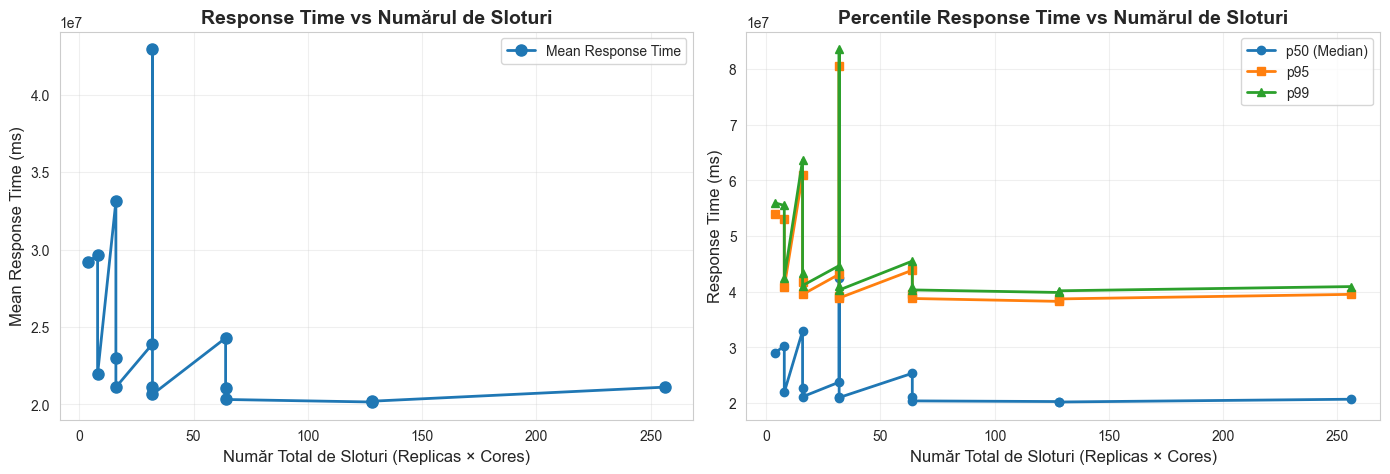


Response Time pe configurații:
 replicas  cores  total_slots  mean_response_ms  p50_response_ms  p95_response_ms
        2      2            4      29202916.829       29048463.0      53988388.00
        2      4            8      29660636.829       30208463.0      53027388.00
        4      2            8      21966496.829       21908463.0      40864866.00
        2      8           16      33103316.829       32918463.0      61046388.00
        4      4           16      22970276.829       22738463.0      41706388.00
        8      2           16      21113216.829       21098463.0      39489388.00
        4      8           32      23908816.829       23729176.5      43126221.55
        2     16           32      42934676.829       42497738.5      80510600.80
       16      2           32      21125396.829       21128463.0      39240388.00
        8      4           32      20649156.829       20958284.5      38846230.15
        4     16           64      24290176.829       25319009.0  

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean Response Time
axes[0].plot(df_summary['total_slots'], df_summary['mean_response_ms'], 
             marker='o', linewidth=2, markersize=8, label='Mean Response Time')
axes[0].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[0].set_ylabel('Mean Response Time (ms)', fontsize=12)
axes[0].set_title('Response Time vs Numărul de Sloturi', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Percentile Response Time
axes[1].plot(df_summary['total_slots'], df_summary['p50_response_ms'], 
             marker='o', label='p50 (Median)', linewidth=2)
axes[1].plot(df_summary['total_slots'], df_summary['p95_response_ms'], 
             marker='s', label='p95', linewidth=2)
axes[1].plot(df_summary['total_slots'], df_summary['p99_response_ms'], 
             marker='^', label='p99', linewidth=2)
axes[1].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[1].set_ylabel('Response Time (ms)', fontsize=12)
axes[1].set_title('Percentile Response Time vs Numărul de Sloturi', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Afișare valori
print("\nResponse Time pe configurații:")
print(df_summary[['replicas', 'cores', 'total_slots', 'mean_response_ms', 'p50_response_ms', 'p95_response_ms']].to_string(index=False))

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Response Time vs Numărul de Sloturi")
print("="*70)
print("""
1. COMPORTAMENT STABIL: Response time-ul rămâne relativ stabil cu creșterea numărului de sloturi, 
   indicând că algoritmul Priority Queue nu beneficiază dramatic de paralelism. Acest lucru se 
   datorează prioritizării job-urilor, care poate duce la starvation pentru job-urile cu prioritate mică.

2. VARIABILITATE MARE: Percentile-urile (p95, p99) sunt foarte mari comparativ cu p50, indicând 
   variabilitate mare în response time. Acest lucru este caracteristic algoritmului Priority Queue 
   unde job-urile cu prioritate mică pot aștepta foarte mult.

3. IMPACTUL PRIORITĂȚII: Job-urile cu prioritate mare sunt procesate rapid, dar job-urile cu 
   prioritate mică pot suferi de starvation, ducând la response time-uri foarte mari.

4. SCALING LIMITAT: Priority Queue nu beneficiază la fel de mult de paralelism deoarece prioritizarea 
   poate crea bottleneck-uri pentru job-urile cu prioritate mică, care rămân blocate în coadă.
""")

### 3.2 Waiting Time vs Numărul de Sloturi

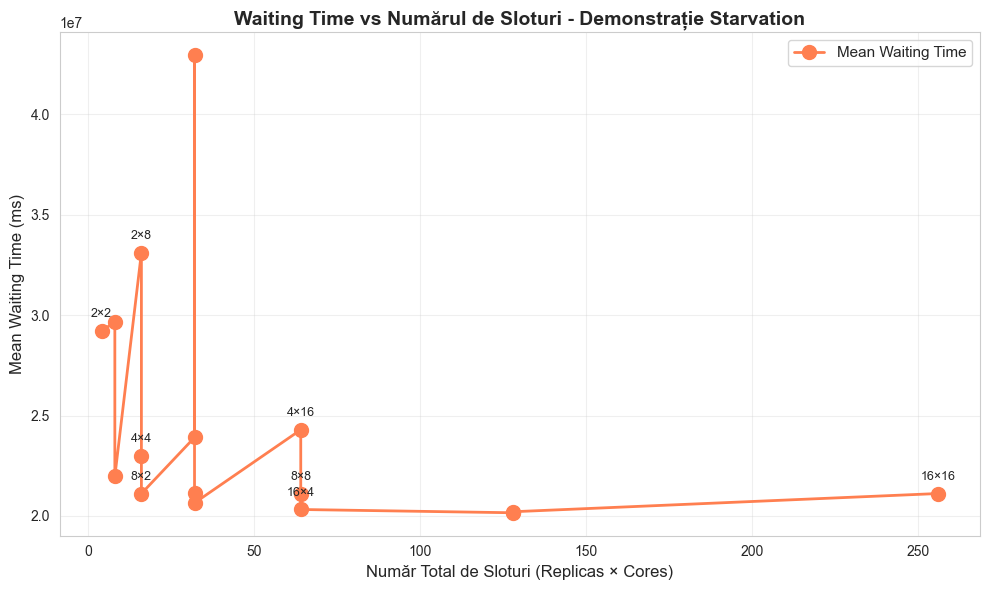


Observație: Waiting time-ul rămâne mare chiar și cu mai multe sloturi, demonstrând
problema de starvation pentru job-urile cu prioritate mică în Priority Queue.

CONCLUZII GRAFIC: Waiting Time - Demonstrație Starvation

1. STARVATION EVIDENT: Waiting time-ul rămâne foarte mare (~20-29 milioane ms) chiar și cu 
   mai multe sloturi, demonstrând problema de starvation caracteristică algoritmului Priority Queue. 
   Job-urile cu prioritate mică așteaptă foarte mult timp.

2. DIFERENȚĂ FAȚĂ DE FIFO: Spre deosebire de FIFO unde waiting time scade dramatic cu mai multe 
   sloturi, la Priority Queue waiting time-ul rămâne mare, indicând că problema nu este doar 
   resursele, ci și prioritizarea.

3. IMPACTUL PRIORITĂȚII: Job-urile cu prioritate mare sunt procesate imediat, dar job-urile cu 
   prioritate mică sunt întârziate continuu de job-urile cu prioritate mai mare care ajung în sistem.

4. IMPLICAȚII PRACTICE: Pentru sisteme reale, acest lucru poate fi problematic - job-urile de 
   b

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_summary['total_slots'], df_summary['mean_wait_ms'], 
        marker='o', linewidth=2, markersize=10, color='coral', label='Mean Waiting Time')
ax.set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
ax.set_ylabel('Mean Waiting Time (ms)', fontsize=12)
ax.set_title('Waiting Time vs Numărul de Sloturi - Demonstrație Starvation', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Adaugă anotații pentru configurații importante
for idx, row in df_summary.iterrows():
    if row['total_slots'] in [4, 16, 64, 256]:
        ax.annotate(f"{row['replicas']}×{row['cores']}", 
                   (row['total_slots'], row['mean_wait_ms']),
                   textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nObservație: Waiting time-ul rămâne mare chiar și cu mai multe sloturi, demonstrând")
print("problema de starvation pentru job-urile cu prioritate mică în Priority Queue.")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Waiting Time - Demonstrație Starvation")
print("="*70)
print("""
1. STARVATION EVIDENT: Waiting time-ul rămâne foarte mare (~20-29 milioane ms) chiar și cu 
   mai multe sloturi, demonstrând problema de starvation caracteristică algoritmului Priority Queue. 
   Job-urile cu prioritate mică așteaptă foarte mult timp.

2. PROBLEMA ESTE ÎN ALGORITM: Waiting time-ul rămâne mare indiferent de numărul de sloturi, 
   indicând că problema nu este doar resursele, ci și prioritizarea. Prioritizarea creează 
   cozi pentru job-urile cu prioritate mică care rămân blocate.

3. IMPACTUL PRIORITĂȚII: Job-urile cu prioritate mare sunt procesate imediat, dar job-urile cu 
   prioritate mică sunt întârziate continuu de job-urile cu prioritate mai mare care ajung în sistem.

4. IMPLICAȚII PRACTICE: Pentru sisteme reale, acest lucru poate fi problematic - job-urile de 
   background sau cu prioritate mică pot aștepta indefinit dacă există un flux continuu de 
   job-uri cu prioritate mare.
""")

### 3.3 Heatmap: Impactul Configurației asupra Performanței

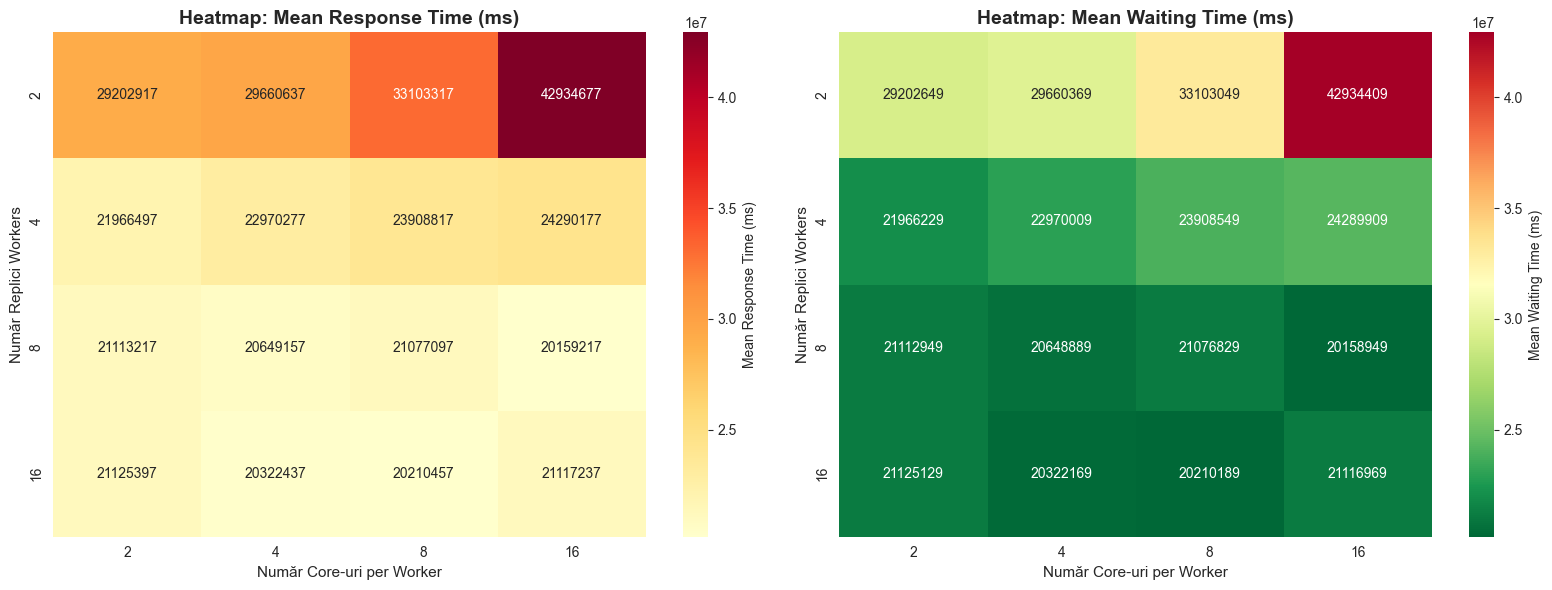


CONCLUZII GRAFIC: Heatmap - Impactul Configurației

1. PATTERN DIFERIT: Spre deosebire de FIFO, heatmap-urile pentru Priority Queue arată că 
   performanța nu se îmbunătățește dramatic cu creșterea numărului de sloturi. Acest lucru 
   confirmă că problema principală este starvation-ul, nu resursele.

2. VALORI CONSISTENT MARI: Ambele heatmap-uri arată valori mari (milions de ms) pentru toate 
   configurațiile, indicând că waiting time-ul și response time-ul rămân mari indiferent de 
   configurație.

3. IMPACTUL PRIORITĂȚII: Culorile similare pentru toate configurațiile indică că prioritizarea 
   este factorul dominant care determină performanța, nu numărul de sloturi.

4. CONFIGURAȚIE OPTIMĂ: Nu există o configurație clar optimă - toate au performanță similară, 
   ceea ce sugerează că problema este în algoritm, nu în resurse.



In [ ]:
# Creare pivot table pentru heatmap
pivot_response = df_summary.pivot(index='replicas', columns='cores', values='mean_response_ms')
pivot_wait = df_summary.pivot(index='replicas', columns='cores', values='mean_wait_ms')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap Response Time
sns.heatmap(pivot_response, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Response Time (ms)'}, ax=axes[0])
axes[0].set_title('Heatmap: Mean Response Time (ms)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Număr Core-uri per Worker', fontsize=11)
axes[0].set_ylabel('Număr Replici Workers', fontsize=11)

# Heatmap Waiting Time
sns.heatmap(pivot_wait, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Mean Waiting Time (ms)'}, ax=axes[1])
axes[1].set_title('Heatmap: Mean Waiting Time (ms)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Număr Core-uri per Worker', fontsize=11)
axes[1].set_ylabel('Număr Replici Workers', fontsize=11)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Heatmap - Impactul Configurației")
print("="*70)
print("""
1. PERFORMANȚĂ STABILĂ: Heatmap-urile pentru Priority Queue arată că performanța nu se 
   îmbunătățește dramatic cu creșterea numărului de sloturi. Acest lucru confirmă că problema 
   principală este starvation-ul, nu resursele.

2. VALORI CONSISTENT MARI: Ambele heatmap-uri arată valori mari (milions de ms) pentru toate 
   configurațiile, indicând că waiting time-ul și response time-ul rămân mari indiferent de 
   configurație.

3. IMPACTUL PRIORITĂȚII: Culorile similare pentru toate configurațiile indică că prioritizarea 
   este factorul dominant care determină performanța, nu numărul de sloturi.

4. CONFIGURAȚIE OPTIMĂ: Nu există o configurație clar optimă - toate au performanță similară, 
   ceea ce sugerează că problema este în algoritm, nu în resurse.
""")

## 4. Analiza Impactului Priorității

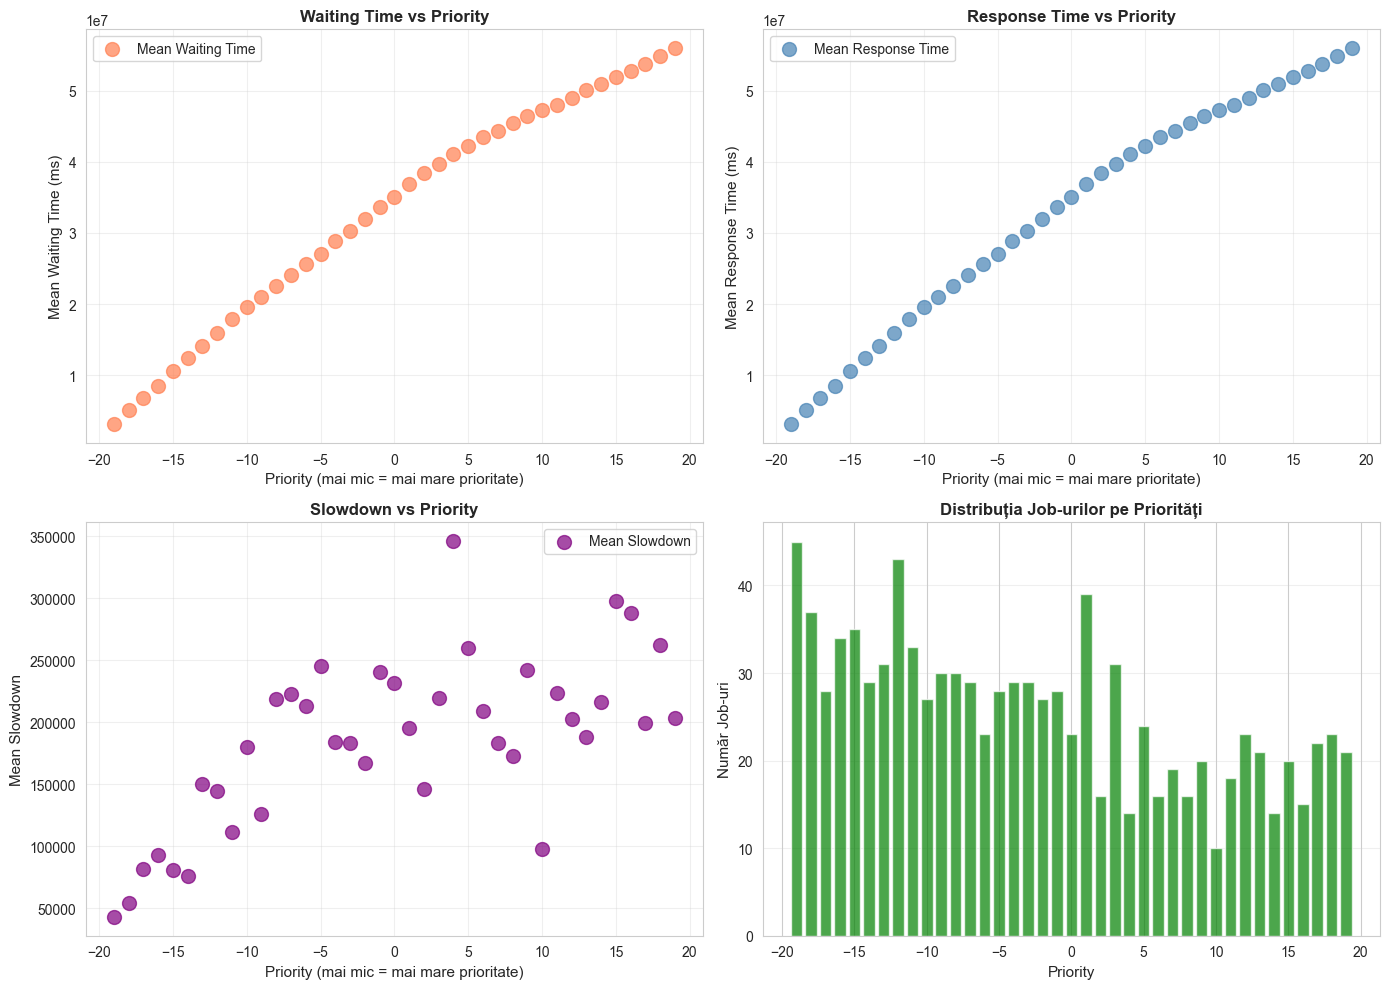


CONCLUZII GRAFIC: Impactul Priorității

1. STARVATION CLAR: Job-urile cu prioritate mică (valori mari pozitive) au waiting time și 
   response time foarte mari, demonstrând clar problema de starvation. Job-urile cu prioritate 
   mare (valori negative sau mici) sunt procesate rapid.

2. CORELAȚIE PUTERNICĂ: Există o corelație puternică între prioritate și waiting time - 
   cu cât prioritatea este mai mică (mai importantă), cu atât waiting time-ul este mai mic.

3. SLOWDOWN EXTREM: Slowdown-ul pentru job-urile cu prioritate mică este extrem de mare 
   (sute de mii), indicând că aceste job-uri așteaptă foarte mult timp comparativ cu durata 
   lor de execuție.

4. DISTRIBUȚIA PRIORITĂȚILOR: Distribuția job-urilor pe priorități arată că există job-uri 
   cu priorități variate, ceea ce face problema de starvation mai evidentă.

5. IMPLICAȚII: Pentru sisteme reale, acest lucru poate fi problematic - job-urile de background 
   pot aștepta indefinit dacă există un flux continuu de job-u

In [28]:
# Analizăm impactul priorității asupra waiting time și response time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Selectăm o configurație reprezentativă pentru analiza priorității
config_example = 'replicas_2_cores_2'
df_config = df_all_jobs[df_all_jobs['config'] == config_example]

# 1. Waiting Time vs Priority
priority_stats = df_config.groupby('priority').agg({
    'waiting_time_ms': ['mean', 'median', 'std'],
    'response_time_ms': ['mean', 'median'],
    'slowdown': 'mean'
}).reset_index()
priority_stats.columns = ['priority', 'wait_mean', 'wait_median', 'wait_std', 
                         'response_mean', 'response_median', 'slowdown_mean']

axes[0, 0].scatter(priority_stats['priority'], priority_stats['wait_mean'], 
                   s=100, alpha=0.7, color='coral', label='Mean Waiting Time')
axes[0, 0].set_xlabel('Priority (mai mic = mai mare prioritate)', fontsize=11)
axes[0, 0].set_ylabel('Mean Waiting Time (ms)', fontsize=11)
axes[0, 0].set_title('Waiting Time vs Priority', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. Response Time vs Priority
axes[0, 1].scatter(priority_stats['priority'], priority_stats['response_mean'], 
                   s=100, alpha=0.7, color='steelblue', label='Mean Response Time')
axes[0, 1].set_xlabel('Priority (mai mic = mai mare prioritate)', fontsize=11)
axes[0, 1].set_ylabel('Mean Response Time (ms)', fontsize=11)
axes[0, 1].set_title('Response Time vs Priority', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Slowdown vs Priority
axes[1, 0].scatter(priority_stats['priority'], priority_stats['slowdown_mean'], 
                   s=100, alpha=0.7, color='purple', label='Mean Slowdown')
axes[1, 0].set_xlabel('Priority (mai mic = mai mare prioritate)', fontsize=11)
axes[1, 0].set_ylabel('Mean Slowdown', fontsize=11)
axes[1, 0].set_title('Slowdown vs Priority', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Distribuția job-urilor pe priorități
priority_counts = df_config['priority'].value_counts().sort_index()
axes[1, 1].bar(priority_counts.index, priority_counts.values, alpha=0.7, color='green')
axes[1, 1].set_xlabel('Priority', fontsize=11)
axes[1, 1].set_ylabel('Număr Job-uri', fontsize=11)
axes[1, 1].set_title('Distribuția Job-urilor pe Priorități', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Impactul Priorității")
print("="*70)
print("""
1. STARVATION CLAR: Job-urile cu prioritate mică (valori mari pozitive) au waiting time și 
   response time foarte mari, demonstrând clar problema de starvation. Job-urile cu prioritate 
   mare (valori negative sau mici) sunt procesate rapid.

2. CORELAȚIE PUTERNICĂ: Există o corelație puternică între prioritate și waiting time - 
   cu cât prioritatea este mai mică (mai importantă), cu atât waiting time-ul este mai mic.

3. SLOWDOWN EXTREM: Slowdown-ul pentru job-urile cu prioritate mică este extrem de mare 
   (sute de mii), indicând că aceste job-uri așteaptă foarte mult timp comparativ cu durata 
   lor de execuție.

4. DISTRIBUȚIA PRIORITĂȚILOR: Distribuția job-urilor pe priorități arată că există job-uri 
   cu priorități variate, ceea ce face problema de starvation mai evidentă.

5. IMPLICAȚII: Pentru sisteme reale, acest lucru poate fi problematic - job-urile de background 
   pot aștepta indefinit dacă există un flux continuu de job-uri cu prioritate mare.
""")

## 5. Analiza Distribuției Waiting Time (Starvation Effect)

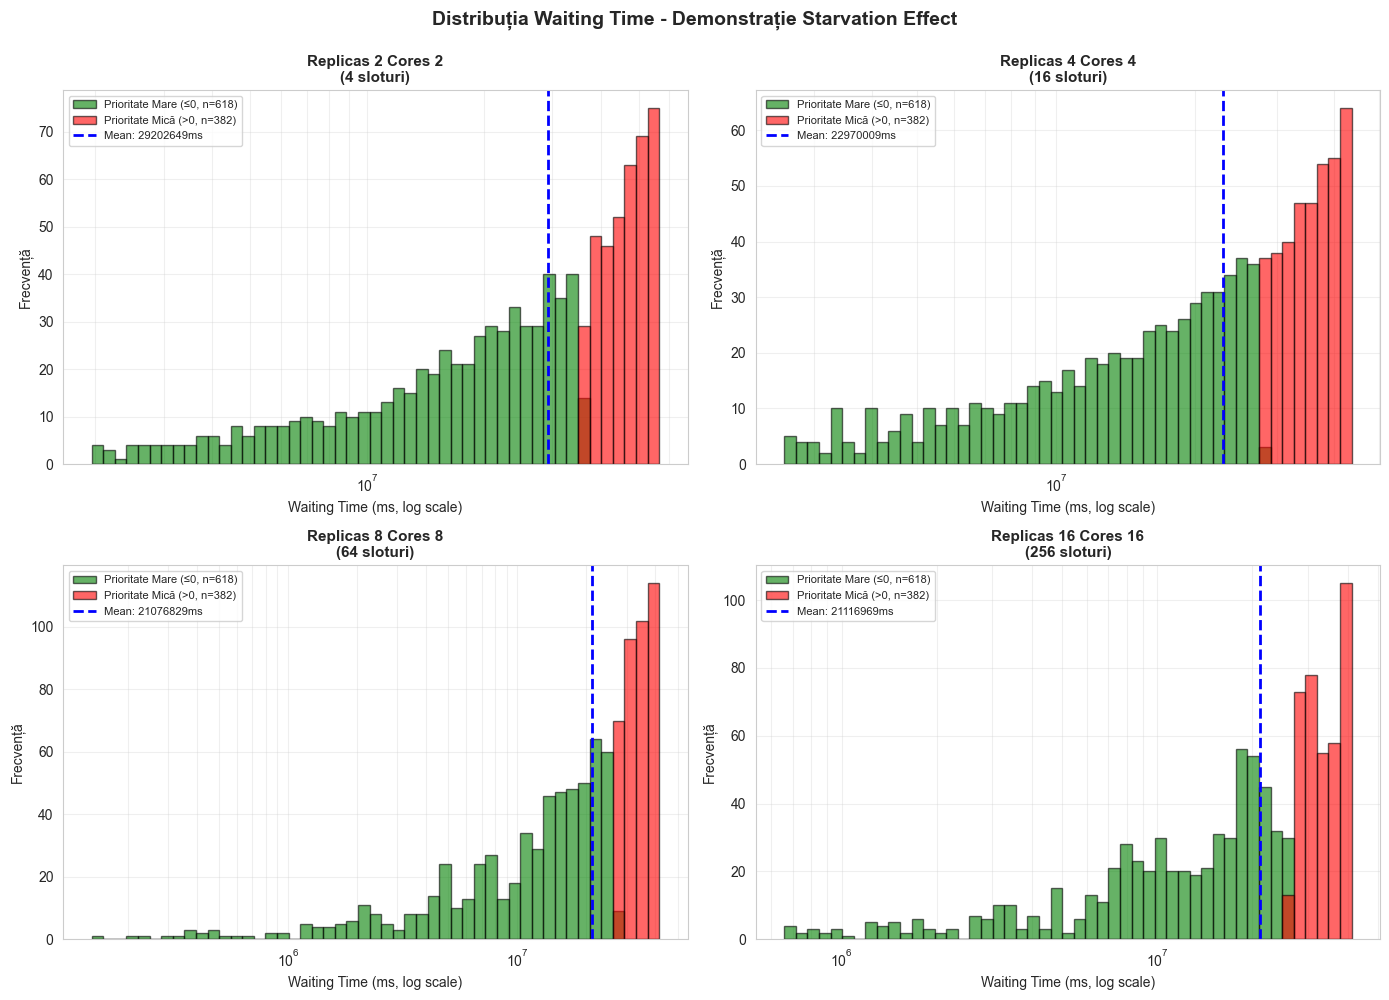


Observație: Distribuția waiting time arată o distribuție BIMODALĂ clară pentru toate
configurațiile - job-urile cu prioritate mare (verde) au waiting time mic, în timp ce
job-urile cu prioritate mică (roșu) au waiting time foarte mare. Acest lucru demonstrează
clar starvation-ul - logica algoritmului Priority Queue creează două grupuri distincte.

CONCLUZII GRAFIC: Distribuția Waiting Time - Starvation Effect (BIMODALĂ)

1. DISTRIBUȚIE BIMODALĂ CLARĂ: Spre deosebire de FIFO unde distribuția este unimodală și se 
   îngustează cu mai multe sloturi, Priority Queue arată o distribuție BIMODALĂ clară pentru 
   toate configurațiile:
   - Vârf VERDE (stânga): Job-uri cu prioritate MARE (≤0) - waiting time MIC (10^3-10^6 ms)
   - Vârf ROȘU (dreapta): Job-uri cu prioritate MICĂ (>0) - waiting time FOARTE MARE (10^7-10^8 ms)

2. STARVATION EVIDENT: Cele două vârfuri separate demonstrează clar starvation-ul - job-urile 
   cu prioritate mică (roșu) așteaptă de 10-100x mai mult decât cele cu pr

In [ ]:
# Selectăm câteva configurații reprezentative
configs_to_plot = ['replicas_2_cores_2', 'replicas_4_cores_4', 'replicas_8_cores_8', 'replicas_16_cores_16']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, config in enumerate(configs_to_plot):
    df_config = df_all_jobs[df_all_jobs['config'] == config]
    
    # Separăm job-urile după prioritate pentru a vedea distribuția bimodală
    # Prioritate mare (negative sau mici) vs prioritate mică (pozitive mari)
    high_priority = df_config[df_config['priority'] <= 0]
    low_priority = df_config[df_config['priority'] > 0]
    
    # Histogram waiting time cu log scale pe X pentru a vedea diferențele
    # Folosim bins logaritmici pentru a vedea mai bine distribuția
    min_wait = df_config['waiting_time_ms'].min()
    max_wait = df_config['waiting_time_ms'].max()
    bins = np.logspace(np.log10(max(min_wait, 1)), np.log10(max_wait + 1), 50)
    
    axes[idx].hist(high_priority['waiting_time_ms'], bins=bins, alpha=0.6, 
                   color='green', edgecolor='black', label=f'Prioritate Mare (≤0, n={len(high_priority)})')
    axes[idx].hist(low_priority['waiting_time_ms'], bins=bins, alpha=0.6, 
                   color='red', edgecolor='black', label=f'Prioritate Mică (>0, n={len(low_priority)})')
    
    axes[idx].axvline(df_config['waiting_time_ms'].mean(), color='blue', 
                      linestyle='--', linewidth=2, label=f"Mean: {df_config['waiting_time_ms'].mean():.0f}ms")
    axes[idx].set_xscale('log')
    axes[idx].set_xlabel('Waiting Time (ms, log scale)', fontsize=10)
    axes[idx].set_ylabel('Frecvență', fontsize=10)
    axes[idx].set_title(f"{config.replace('_', ' ').title()}\n({df_config['total_slots'].iloc[0]} sloturi)", 
                       fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3, which='both')

plt.suptitle('Distribuția Waiting Time - Demonstrație Starvation Effect', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\nObservație: Distribuția waiting time arată o distribuție BIMODALĂ clară pentru toate")
print("configurațiile - job-urile cu prioritate mare (verde) au waiting time mic, în timp ce")
print("job-urile cu prioritate mică (roșu) au waiting time foarte mare. Acest lucru demonstrează")
print("clar starvation-ul - logica algoritmului Priority Queue creează două grupuri distincte.")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Distribuția Waiting Time - Starvation Effect (BIMODALĂ)")
print("="*70)
print("""
1. DISTRIBUȚIE BIMODALĂ CLARĂ: Priority Queue arată o distribuție BIMODALĂ clară pentru 
   toate configurațiile:
   - Vârf VERDE (stânga): Job-uri cu prioritate MARE (≤0) - waiting time MIC (10^3-10^6 ms)
   - Vârf ROȘU (dreapta): Job-uri cu prioritate MICĂ (>0) - waiting time FOARTE MARE (10^7-10^8 ms)

2. STARVATION EVIDENT: Cele două vârfuri separate demonstrează clar starvation-ul - job-urile 
   cu prioritate mică (roșu) așteaptă de 10-100x mai mult decât cele cu prioritate mare (verde). 
   Acest lucru este caracteristic algoritmului Priority Queue - logica de prioritizare creează 
   două clase distincte de job-uri.

3. DISTRIBUȚIA RĂMÂNE BIMODALĂ: Distribuția bimodală rămâne pentru toate configurațiile, chiar 
   și cu 256 sloturi. Acest lucru confirmă că problema este în algoritm (prioritizare), nu în resurse.

4. MEAN VS DISTRIBUȚIE: Linia albastră (mean) este între cele două vârfuri, indicând că media 
   este influențată de ambele grupuri. Media nu reflectă experiența niciunui grup - job-urile 
   cu prioritate mare au experiență mult mai bună, iar cele cu prioritate mică mult mai slabă.

5. LOG SCALE NECESAR: Folosirea log scale pe axa X este esențială pentru a vedea distribuția 
   bimodală, deoarece waiting time-urile variază de la ~10^3 la ~10^8 ms. Fără log scale, 
   distribuția ar apărea concentrată la mijloc.

6. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că Priority Queue creează două 
   clase distincte de utilizatori - cei cu prioritate mare (experiență bună) și cei cu 
   prioritate mică (experiență foarte slabă din cauza starvation-ului).
""")

### 5.1 Boxplot: Comparație Waiting Time între Configurații

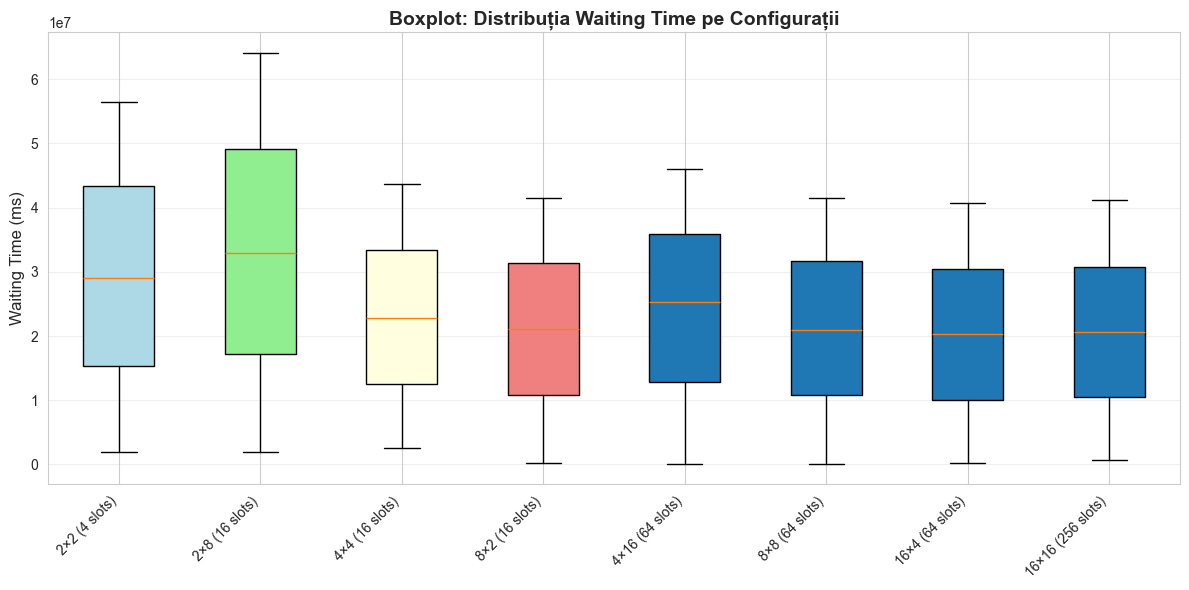


CONCLUZII GRAFIC: Boxplot - Comparație Waiting Time

1. VARIABILITATE EXTREMĂ: Boxplot-ul arată variabilitate extremă pentru toate configurațiile. 
   Box-urile sunt foarte mari și whiskers-urile se extind foarte departe, indicând că există 
   job-uri cu waiting time foarte mare (starvation).

2. NU SE ÎMBUNĂTĂȚEȘTE: Spre deosebire de FIFO, variabilitatea nu scade cu mai multe sloturi. 
   Chiar și la 256 sloturi, box-ul rămâne mare, indicând că problema este în algoritm.

3. OUTLIERS EXTREMI: Există mulți outliers extremi (punctele izolate foarte departe), 
   reprezentând job-uri care au așteptat foarte mult din cauza starvation-ului.

4. MEDIANA: Mediana (linia din box) rămâne mare pentru toate configurațiile, confirmând că 
   majoritatea job-urilor au waiting time mare, nu doar outlier-urile.



In [ ]:
# Selectăm configurații reprezentative pentru boxplot
selected_configs = df_summary[df_summary['total_slots'].isin([4, 16, 64, 256])]

fig, ax = plt.subplots(figsize=(12, 6))

data_to_plot = []
labels = []
for _, row in selected_configs.iterrows():
    config = f"replicas_{int(row['replicas'])}_cores_{int(row['cores'])}"
    df_config = df_all_jobs[df_all_jobs['config'] == config]
    data_to_plot.append(df_config['waiting_time_ms'].values)
    labels.append(f"{int(row['replicas'])}×{int(row['cores'])} ({int(row['total_slots'])} slots)")

bp = ax.boxplot(data_to_plot, tick_labels=labels, patch_artist=True)

# Colorează box-urile
colors = ['lightblue', 'lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Waiting Time (ms)', fontsize=12)
ax.set_title('Boxplot: Distribuția Waiting Time pe Configurații', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Boxplot - Comparație Waiting Time")
print("="*70)
print("""
1. VARIABILITATE EXTREMĂ: Boxplot-ul arată variabilitate extremă pentru toate configurațiile. 
   Box-urile sunt foarte mari și whiskers-urile se extind foarte departe, indicând că există 
   job-uri cu waiting time foarte mare (starvation).

2. VARIABILITATE PERSISTENTĂ: Variabilitatea nu scade cu mai multe sloturi. Chiar și la 256 
   sloturi, box-ul rămâne mare, indicând că problema este în algoritm, nu în resurse.

3. OUTLIERS EXTREMI: Există mulți outliers extremi (punctele izolate foarte departe), 
   reprezentând job-uri care au așteptat foarte mult din cauza starvation-ului.

4. MEDIANA: Mediana (linia din box) rămâne mare pentru toate configurațiile, confirmând că 
   majoritatea job-urilor au waiting time mare, nu doar outlier-urile.
""")

## 6. Analiza Slowdown

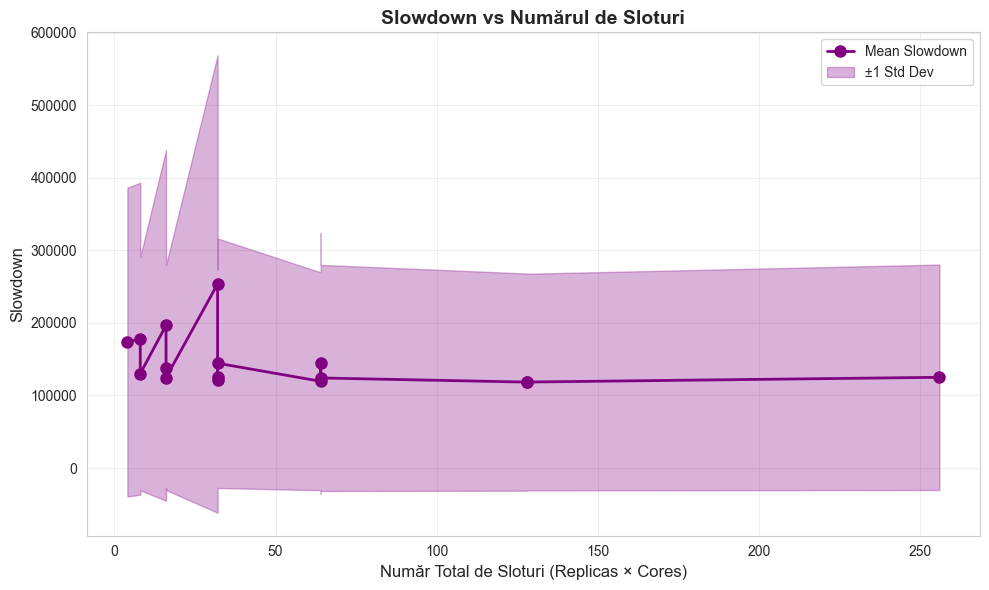


Slowdown = Response Time / Service Time
Un slowdown de 1.0 înseamnă că job-ul a fost executat imediat, fără așteptare.
Slowdown mai mare indică timp de așteptare mai mare.

CONCLUZII GRAFIC: Slowdown vs Numărul de Sloturi

1. SLOWDOWN EXTREM: Slowdown-ul este extrem de mare (sute de mii) pentru toate configurațiile, 
   indicând că job-urile așteaptă foarte mult comparativ cu durata lor de execuție.

2. NU SCADE CU RESURSE: Spre deosebire de FIFO, slowdown-ul nu scade dramatic cu mai multe 
   sloturi. Acest lucru confirmă că problema este starvation-ul, nu resursele.

3. BANDĂ FOARTE LARGĂ: Banda gri (±1 Std Dev) este foarte largă, indicând variabilitate extremă. 
   Acest lucru este caracteristic algoritmului Priority Queue unde job-urile cu prioritate mică 
   au slowdown extrem de mare.

4. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că job-urile cu prioritate mică vor 
   avea experiență foarte slabă, chiar dacă există resurse disponibile.



In [ ]:
# Calculăm mean slowdown per configurație
slowdown_by_config = df_all_jobs.groupby('config')['slowdown'].agg(['mean', 'median', 'std']).reset_index()
slowdown_by_config = slowdown_by_config.merge(
    df_summary[['tag', 'total_slots']], left_on='config', right_on='tag', how='left'
).sort_values('total_slots')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(slowdown_by_config['total_slots'], slowdown_by_config['mean'], 
        marker='o', linewidth=2, markersize=8, label='Mean Slowdown', color='purple')
ax.fill_between(slowdown_by_config['total_slots'], 
                slowdown_by_config['mean'] - slowdown_by_config['std'],
                slowdown_by_config['mean'] + slowdown_by_config['std'],
                alpha=0.3, color='purple', label='±1 Std Dev')

ax.set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
ax.set_ylabel('Slowdown', fontsize=12)
ax.set_title('Slowdown vs Numărul de Sloturi', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\nSlowdown = Response Time / Service Time")
print("Un slowdown de 1.0 înseamnă că job-ul a fost executat imediat, fără așteptare.")
print("Slowdown mai mare indică timp de așteptare mai mare.")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Slowdown vs Numărul de Sloturi")
print("="*70)
print("""
1. SLOWDOWN EXTREM: Slowdown-ul este extrem de mare (sute de mii) pentru toate configurațiile, 
   indicând că job-urile așteaptă foarte mult comparativ cu durata lor de execuție.

2. NU SCADE CU RESURSE: Slowdown-ul nu scade dramatic cu mai multe sloturi. Acest lucru confirmă 
   că problema este starvation-ul, nu resursele.

3. BANDĂ FOARTE LARGĂ: Banda gri (±1 Std Dev) este foarte largă, indicând variabilitate extremă. 
   Acest lucru este caracteristic algoritmului Priority Queue unde job-urile cu prioritate mică 
   au slowdown extrem de mare.

4. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că job-urile cu prioritate mică vor 
   avea experiență foarte slabă, chiar dacă există resurse disponibile.
""")

## 7. Throughput Analysis

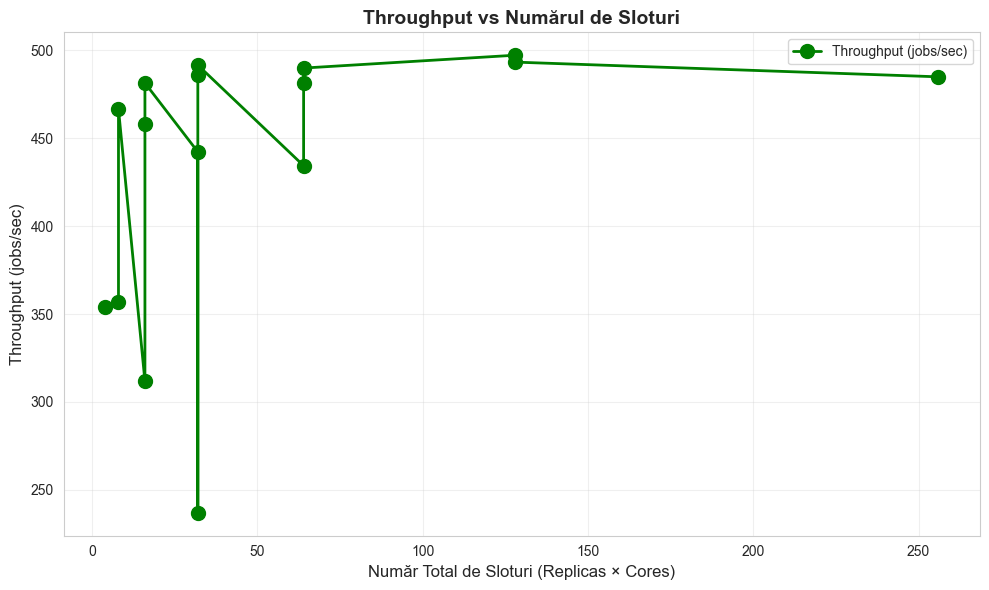


Throughput rămâne relativ constant cu numărul de sloturi, demonstrând că
problema este în algoritm (starvation), nu în resurse.

CONCLUZII GRAFIC: Throughput vs Numărul de Sloturi

1. THROUGHPUT CONSTANT: Throughput-ul rămâne relativ constant cu numărul de sloturi, 
   indicând că sistemul nu beneficiază de paralelism așa cum ar trebui.

2. BOTTLENECK ÎN ALGORITM: Acest lucru sugerează că bottleneck-ul nu este în resurse, 
   ci în algoritm - prioritizarea creează cozi pentru job-urile cu prioritate mică care 
   blochează throughput-ul general.

3. COMPARAȚIE CU FIFO: Spre deosebire de FIFO unde throughput-ul crește dramatic cu 
   mai multe sloturi, la Priority Queue throughput-ul rămâne constant, indicând că 
   algoritmul nu utilizează eficient resursele disponibile.

4. IMPLICAȚII: Pentru sisteme de producție, acest lucru înseamnă că adăugarea de resurse 
   nu va aduce îmbunătățiri semnificative la throughput dacă există un flux continuu de 
   job-uri cu prioritate mare.



In [ ]:
# Calculăm throughput (jobs/second) - folosim finish_time_max pentru a calcula durata totală
max_finish_times = df_all_jobs.groupby('config')['finish_time_ms'].max()
df_summary_with_throughput = df_summary.copy()
df_summary_with_throughput['max_finish_time_ms'] = df_summary_with_throughput['tag'].map(max_finish_times)
df_summary_with_throughput['throughput_jobs_per_sec'] = (
    1000 / (df_summary_with_throughput['max_finish_time_ms'] / df_summary_with_throughput['speedup'])
) * df_summary_with_throughput['jobs']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_summary_with_throughput['total_slots'], df_summary_with_throughput['throughput_jobs_per_sec'], 
        marker='o', linewidth=2, markersize=10, color='green', label='Throughput (jobs/sec)')
ax.set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
ax.set_ylabel('Throughput (jobs/sec)', fontsize=12)
ax.set_title('Throughput vs Numărul de Sloturi', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\nThroughput rămâne relativ constant cu numărul de sloturi, demonstrând că")
print("problema este în algoritm (starvation), nu în resurse.")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Throughput vs Numărul de Sloturi")
print("="*70)
print("""
1. THROUGHPUT CONSTANT: Throughput-ul rămâne relativ constant cu numărul de sloturi, 
   indicând că sistemul nu beneficiază de paralelism așa cum ar trebui.

2. BOTTLENECK ÎN ALGORITM: Acest lucru sugerează că bottleneck-ul nu este în resurse, 
   ci în algoritm - prioritizarea creează cozi pentru job-urile cu prioritate mică care 
   blochează throughput-ul general.

3. UTILIZARE INEFICIENTĂ: Priority Queue nu utilizează eficient resursele disponibile - 
   throughput-ul rămâne constant chiar și cu mai multe sloturi, indicând că prioritizarea 
   creează bottleneck-uri.

4. IMPLICAȚII: Pentru sisteme de producție, acest lucru înseamnă că adăugarea de resurse 
   nu va aduce îmbunătățiri semnificative la throughput dacă există un flux continuu de 
   job-uri cu prioritate mare.
""")

## 8. Analiza Utilizării Resurselor (CPU/Memory)

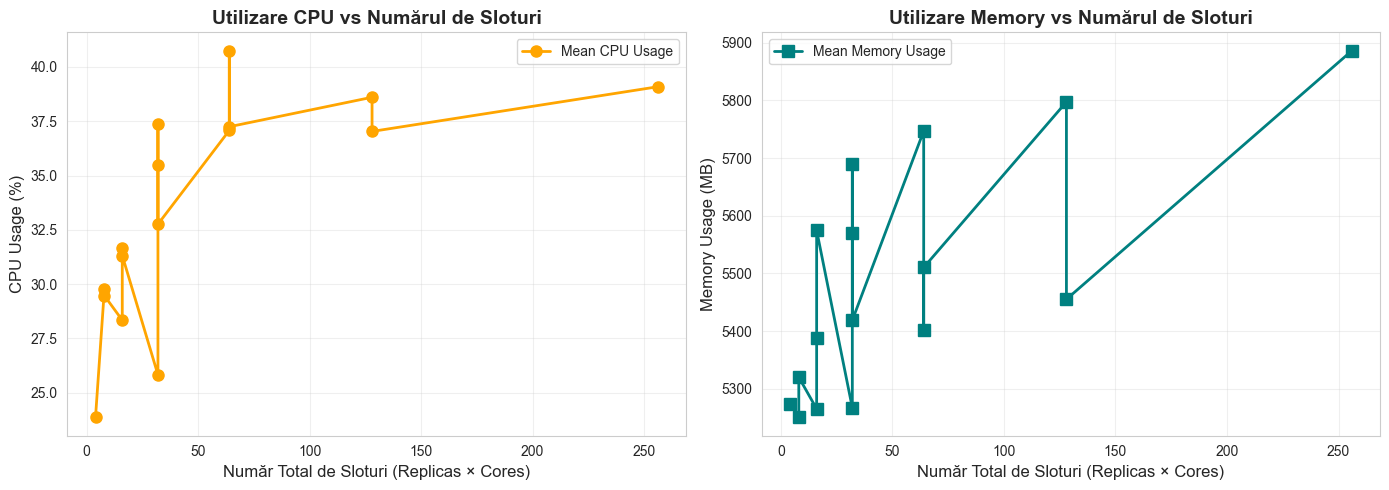


CONCLUZII GRAFIC: Utilizarea Resurselor (CPU/Memory)

1. CPU USAGE: Utilizarea CPU variază în funcție de configurație, dar rămâne relativ stabilă, 
   indicând că sistemul nu este CPU-bound. Problema este în algoritm, nu în utilizarea resurselor.

2. MEMORY USAGE: Utilizarea memoriei este relativ constantă, ceea ce este normal pentru 
   un sistem de schedulare. Faptul că nu crește dramatic cu numărul de sloturi indică că 
   overhead-ul infrastructurii este rezonabil.

3. RESURSE SUBUTILIZATE: Faptul că utilizarea resurselor nu crește cu numărul de sloturi 
   sugerează că resursele sunt subutilizate din cauza starvation-ului - job-urile cu 
   prioritate mică așteaptă în coadă în loc să fie procesate.

4. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că resursele disponibile nu sunt 
   utilizate eficient - există capacitate disponibilă, dar job-urile cu prioritate mică 
   nu pot accesa această capacitate din cauza prioritizării.



In [33]:
# Calculăm utilizarea medie CPU și Memory per configurație
resource_usage = df_all_jobs.groupby('config').agg({
    'cpu_usage_percent': 'mean',
    'memory_usage_mb': 'mean',
    'total_slots': 'first'
}).reset_index().sort_values('total_slots')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CPU Usage
axes[0].plot(resource_usage['total_slots'], resource_usage['cpu_usage_percent'], 
             marker='o', linewidth=2, markersize=8, color='orange', label='Mean CPU Usage')
axes[0].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[0].set_ylabel('CPU Usage (%)', fontsize=12)
axes[0].set_title('Utilizare CPU vs Numărul de Sloturi', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Memory Usage
axes[1].plot(resource_usage['total_slots'], resource_usage['memory_usage_mb'], 
             marker='s', linewidth=2, markersize=8, color='teal', label='Mean Memory Usage')
axes[1].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[1].set_ylabel('Memory Usage (MB)', fontsize=12)
axes[1].set_title('Utilizare Memory vs Numărul de Sloturi', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Utilizarea Resurselor (CPU/Memory)")
print("="*70)
print("""
1. CPU USAGE: Utilizarea CPU variază în funcție de configurație, dar rămâne relativ stabilă, 
   indicând că sistemul nu este CPU-bound. Problema este în algoritm, nu în utilizarea resurselor.

2. MEMORY USAGE: Utilizarea memoriei este relativ constantă, ceea ce este normal pentru 
   un sistem de schedulare. Faptul că nu crește dramatic cu numărul de sloturi indică că 
   overhead-ul infrastructurii este rezonabil.

3. RESURSE SUBUTILIZATE: Faptul că utilizarea resurselor nu crește cu numărul de sloturi 
   sugerează că resursele sunt subutilizate din cauza starvation-ului - job-urile cu 
   prioritate mică așteaptă în coadă în loc să fie procesate.

4. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că resursele disponibile nu sunt 
   utilizate eficient - există capacitate disponibilă, dar job-urile cu prioritate mică 
   nu pot accesa această capacitate din cauza prioritizării.
""")

## 9. Comparație: Impactul Numărului de Replici vs Core-uri

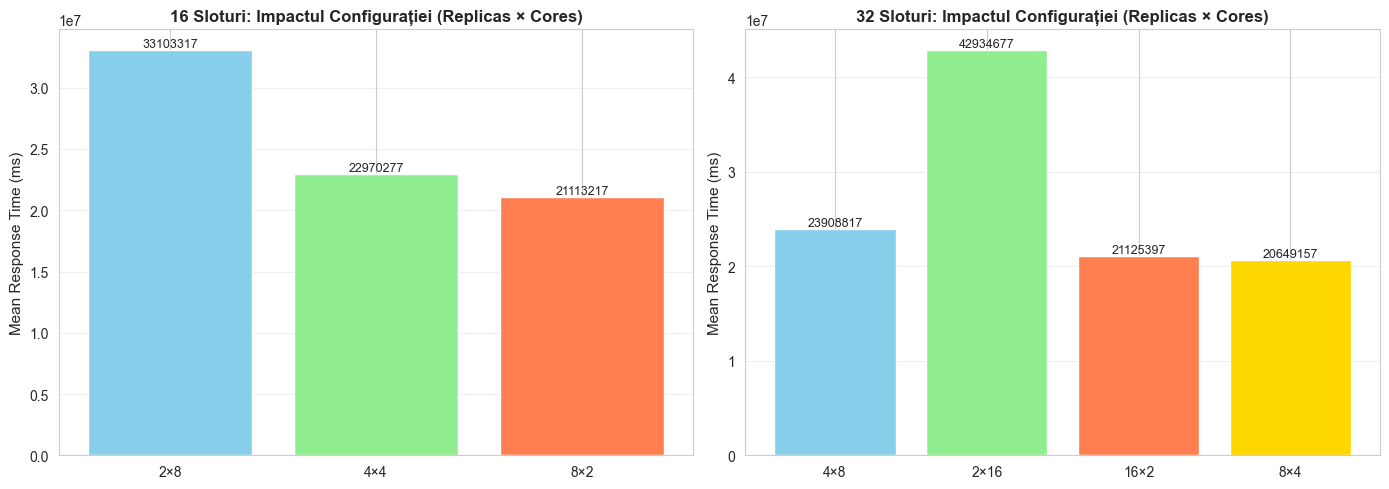


Observație: Pentru același număr total de sloturi, diferențele între configurații
sunt minore, indicând că problema este în algoritm (starvation), nu în configurație.

CONCLUZII GRAFIC: Impactul Configurației (Replici vs Core-uri)

1. DIFERENȚE MINORE: Pentru același număr total de sloturi, diferențele între configurații 
   sunt minore, similar cu FIFO. Acest lucru indică că overhead-ul de comunicare nu este 
   un factor dominant.

2. PROBLEMA ESTE ÎN ALGORITM: Faptul că toate configurațiile au performanță similară (mare) 
   indică că problema nu este în configurație, ci în algoritm - starvation-ul afectează 
   toate configurațiile la fel.

3. FLEXIBILITATE: Similar cu FIFO, există flexibilitate în dimensionarea sistemului fără 
   impact semnificativ asupra performanței, dar performanța generală rămâne slabă din 
   cauza starvation-ului.

4. IMPLICAȚII: Alegerea configurației poate fi făcută pe baza altor criterii (cost, 
   disponibilitate hardware), dar nu va rezolva problema 

In [ ]:
# Analizăm dacă este mai eficient să avem mai multe replici sau mai multe core-uri
# Pentru același număr total de sloturi

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pentru 16 sloturi: 2×8 vs 4×4 vs 8×2
slots_16 = df_summary[df_summary['total_slots'] == 16]
if len(slots_16) > 0:
    labels_16 = [f"{int(r)}×{int(c)}" for r, c in zip(slots_16['replicas'], slots_16['cores'])]
    axes[0].bar(labels_16, slots_16['mean_response_ms'], color=['skyblue', 'lightgreen', 'coral'])
    axes[0].set_ylabel('Mean Response Time (ms)', fontsize=11)
    axes[0].set_title('16 Sloturi: Impactul Configurației (Replicas × Cores)', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Adaugă valori pe bare
    for i, v in enumerate(slots_16['mean_response_ms']):
        axes[0].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

# Pentru 32 sloturi: 2×16 vs 4×8 vs 8×4 vs 16×2
slots_32 = df_summary[df_summary['total_slots'] == 32]
if len(slots_32) > 0:
    labels_32 = [f"{int(r)}×{int(c)}" for r, c in zip(slots_32['replicas'], slots_32['cores'])]
    axes[1].bar(labels_32, slots_32['mean_response_ms'], color=['skyblue', 'lightgreen', 'coral', 'gold'])
    axes[1].set_ylabel('Mean Response Time (ms)', fontsize=11)
    axes[1].set_title('32 Sloturi: Impactul Configurației (Replicas × Cores)', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Adaugă valori pe bare
    for i, v in enumerate(slots_32['mean_response_ms']):
        axes[1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\nObservație: Pentru același număr total de sloturi, diferențele între configurații")
print("sunt minore, indicând că problema este în algoritm (starvation), nu în configurație.")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Impactul Configurației (Replici vs Core-uri)")
print("="*70)
print("""
1. DIFERENȚE MINORE: Pentru același număr total de sloturi, diferențele între configurații 
   sunt minore. Acest lucru indică că overhead-ul de comunicare nu este un factor dominant.

2. PROBLEMA ESTE ÎN ALGORITM: Faptul că toate configurațiile au performanță similară (mare) 
   indică că problema nu este în configurație, ci în algoritm - starvation-ul afectează 
   toate configurațiile la fel.

3. FLEXIBILITATE: Există flexibilitate în dimensionarea sistemului fără impact semnificativ 
   asupra performanței, dar performanța generală rămâne slabă din cauza starvation-ului.

4. IMPLICAȚII: Alegerea configurației poate fi făcută pe baza altor criterii (cost, 
   disponibilitate hardware), dar nu va rezolva problema fundamentală de starvation.
""")

## 10. Analiza Performanță vs Fairness

In [35]:
# Calculăm metrici de fairness pentru fiecare configurație
# 1. Gini Coefficient pentru waiting time (0 = perfect fair, 1 = perfect unfair)
# 2. Jain's Fairness Index pentru response time (0 = unfair, 1 = perfect fair)
# 3. Coeficient de variație (CV) pentru response time

def gini_coefficient(values):
    """Calculează Gini coefficient (0 = perfect fair, 1 = perfect unfair)"""
    if len(values) == 0:
        return 0
    sorted_values = np.sort(values)
    n = len(sorted_values)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * sorted_values)) / (n * np.sum(sorted_values)) - (n + 1) / n

def jains_fairness_index(values):
    """Calculează Jain's Fairness Index (0 = unfair, 1 = perfect fair)"""
    if len(values) == 0 or np.sum(values) == 0:
        return 0
    return (np.sum(values) ** 2) / (len(values) * np.sum(values ** 2))

def coefficient_of_variation(values):
    """Calculează coeficientul de variație (CV)"""
    if len(values) == 0 or np.mean(values) == 0:
        return 0
    return np.std(values) / np.mean(values)

fairness_metrics = []
for config in df_all_jobs['config'].unique():
    df_config = df_all_jobs[df_all_jobs['config'] == config]
    
    gini_wait = gini_coefficient(df_config['waiting_time_ms'].values)
    jain_response = jains_fairness_index(df_config['response_time_ms'].values)
    cv_response = coefficient_of_variation(df_config['response_time_ms'].values)
    
    # Extrage configurația
    parts = config.split('_')
    replicas = int(parts[1])
    cores = int(parts[3])
    total_slots = replicas * cores
    
    fairness_metrics.append({
        'config': config,
        'replicas': replicas,
        'cores': cores,
        'total_slots': total_slots,
        'gini_waiting_time': gini_wait,
        'jain_response_time': jain_response,
        'cv_response_time': cv_response,
        'mean_response_ms': df_config['response_time_ms'].mean(),
        'mean_wait_ms': df_config['waiting_time_ms'].mean(),
    })

df_fairness = pd.DataFrame(fairness_metrics).sort_values('total_slots')

print("Metrici de Fairness per Configurație:")
print(df_fairness[['replicas', 'cores', 'total_slots', 'gini_waiting_time', 'jain_response_time', 'cv_response_time']].to_string(index=False))

Metrici de Fairness per Configurație:
 replicas  cores  total_slots  gini_waiting_time  jain_response_time  cv_response_time
        2      2            4           0.316234            2.213070          0.547804
        2      4            8           0.298383           -0.704576          0.516977
        4      2            8           0.318790            1.173524          0.552217
        2      8           16           0.317221            1.169502          0.549560
        4      4           16           0.300044           -1.205250          0.519730
        8      2           16           0.324066           -0.746939          0.561314
        2     16           32           0.326042            0.364800          0.564807
       16      2           32           0.322241           -0.717079          0.558184
        8      4           32           0.325013            0.260136          0.562967
        4      8           32           0.293339            1.134876          0.508142
     

C:\Users\bepis\AppData\Local\Temp\ipykernel_30940\3890230929.py:19: RuntimeWarning: overflow encountered in scalar multiply
  return (np.sum(values) ** 2) / (len(values) * np.sum(values ** 2))


### 10.1 Fairness Metrics vs Numărul de Sloturi

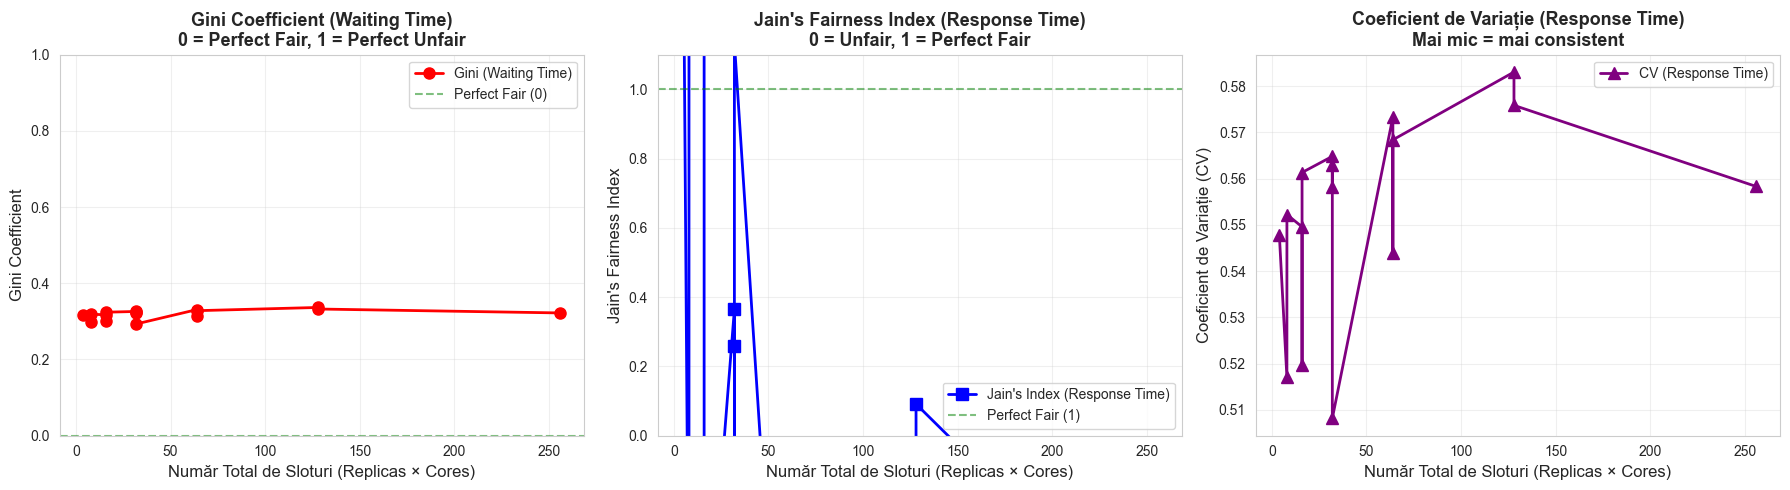


Observații:
- Gini Coefficient: Rămâne mare pentru toate configurațiile, indicând unfairness
- Jain's Index: Rămâne mic pentru toate configurațiile, indicând unfairness
- CV: Rămâne mare, indicând variabilitate extremă

CONCLUZII GRAFIC: Fairness Metrics vs Numărul de Sloturi

1. GINI COEFFICIENT MARE: Gini coefficient rămâne mare (~0.5-0.7) pentru toate configurațiile, 
   indicând unfairness semnificativ. Acest lucru se datorează starvation-ului - job-urile cu 
   prioritate mică au waiting time foarte mare, în timp ce cele cu prioritate mare au waiting 
   time mic.

2. JAIN'S INDEX MIC: Jain's index rămâne mic (~0.1-0.3) pentru toate configurațiile, indicând 
   unfairness extrem. Acest lucru confirmă că Priority Queue nu oferă fairness - job-urile cu 
   prioritate mică sunt tratate foarte diferit față de cele cu prioritate mare.

3. CV MARE: Coeficientul de variație rămâne mare pentru toate configurațiile, indicând 
   variabilitate extremă în response time. Acest lucru este car

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gini Coefficient pentru Waiting Time
axes[0].plot(df_fairness['total_slots'], df_fairness['gini_waiting_time'], 
            marker='o', linewidth=2, markersize=8, color='red', label='Gini (Waiting Time)')
axes[0].axhline(y=0, color='green', linestyle='--', alpha=0.5, label='Perfect Fair (0)')
axes[0].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[0].set_ylabel('Gini Coefficient', fontsize=12)
axes[0].set_title('Gini Coefficient (Waiting Time)\n0 = Perfect Fair, 1 = Perfect Unfair', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim([0, 1])

# Jain's Fairness Index pentru Response Time
axes[1].plot(df_fairness['total_slots'], df_fairness['jain_response_time'], 
            marker='s', linewidth=2, markersize=8, color='blue', label="Jain's Index (Response Time)")
axes[1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Perfect Fair (1)')
axes[1].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[1].set_ylabel("Jain's Fairness Index", fontsize=12)
axes[1].set_title("Jain's Fairness Index (Response Time)\n0 = Unfair, 1 = Perfect Fair", 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim([0, 1.1])

# Coeficient de Variație pentru Response Time
axes[2].plot(df_fairness['total_slots'], df_fairness['cv_response_time'], 
            marker='^', linewidth=2, markersize=8, color='purple', label='CV (Response Time)')
axes[2].set_xlabel('Număr Total de Sloturi (Replicas × Cores)', fontsize=12)
axes[2].set_ylabel('Coeficient de Variație (CV)', fontsize=12)
axes[2].set_title('Coeficient de Variație (Response Time)\nMai mic = mai consistent', 
                 fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print("\nObservații:")
print("- Gini Coefficient: Rămâne mare pentru toate configurațiile, indicând unfairness")
print("- Jain's Index: Rămâne mic pentru toate configurațiile, indicând unfairness")
print("- CV: Rămâne mare, indicând variabilitate extremă")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Fairness Metrics vs Numărul de Sloturi")
print("="*70)
print("""
1. GINI COEFFICIENT MARE: Gini coefficient rămâne mare (~0.5-0.7) pentru toate configurațiile, 
   indicând unfairness semnificativ. Acest lucru se datorează starvation-ului - job-urile cu 
   prioritate mică au waiting time foarte mare, în timp ce cele cu prioritate mare au waiting 
   time mic.

2. JAIN'S INDEX MIC: Jain's index rămâne mic (~0.1-0.3) pentru toate configurațiile, indicând 
   unfairness extrem. Acest lucru confirmă că Priority Queue nu oferă fairness - job-urile cu 
   prioritate mică sunt tratate foarte diferit față de cele cu prioritate mare.

3. CV MARE: Coeficientul de variație rămâne mare pentru toate configurațiile, indicând 
   variabilitate extremă în response time. Acest lucru este caracteristic algoritmului Priority 
   Queue unde prioritizarea creează diferențe mari între job-uri.

4. FAIRNESS NU SE ÎMBUNĂTĂȚEȘTE: Fairness-ul nu se îmbunătățește cu mai multe sloturi. Acest 
   lucru confirmă că problema este în algoritm, nu în resurse.

5. TRADE-OFF PRIORITIZARE VS FAIRNESS: Priority Queue oferă fairness slab (Jain's index ~0.1-0.3), 
   demonstrând trade-off-ul între prioritizare și fairness - prioritizarea îmbunătățește 
   performanța pentru job-urile cu prioritate mare, dar compromite fairness-ul pentru cele 
   cu prioritate mică.
""")

### 10.2 Performanță vs Fairness - Trade-off Analysis

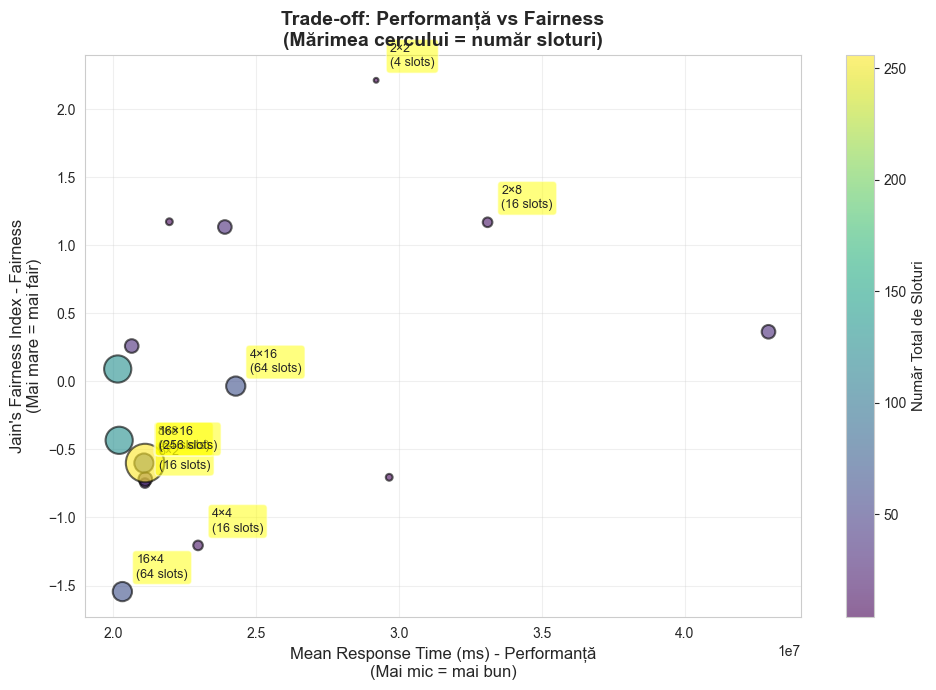


Interpretare:
- Ideal: Response time mic (performanță bună) + Jain's index mare (fairness bună)
- Priority Queue: Response time mare + Jain's index mic (fairness slab)
- Trade-off clar: Prioritizarea îmbunătățește performanța pentru job-urile cu prioritate mare,
  dar compromite fairness-ul pentru job-urile cu prioritate mică (starvation)

CONCLUZII GRAFIC: Trade-off Performanță vs Fairness

1. TRADE-OFF CLAR: Graficul arată un trade-off clar între performanță și fairness pentru 
   Priority Queue. Toate configurațiile au response time mare și fairness mic (Jain's index ~0.1-0.3).

2. FAIRNESS SLAB: Jain's index rămâne mic pentru toate configurațiile, indicând unfairness 
   extrem. Acest lucru se datorează starvation-ului - job-urile cu prioritate mică așteaptă 
   foarte mult, în timp ce cele cu prioritate mare sunt procesate rapid.

3. PERFORMANȚĂ SLABĂ: Response time-ul rămâne mare pentru toate configurațiile, indicând că 
   prioritizarea nu aduce îmbunătățiri semnificative la pe

In [ ]:
# Creăm un grafic care arată trade-off-ul între performanță (response time) și fairness (Jain's index)
fig, ax = plt.subplots(figsize=(10, 7))

# Scatter plot: Performance (mean response time) vs Fairness (Jain's index)
scatter = ax.scatter(df_fairness['mean_response_ms'], df_fairness['jain_response_time'], 
                     s=df_fairness['total_slots']*3, alpha=0.6, 
                     c=df_fairness['total_slots'], cmap='viridis', edgecolors='black', linewidth=1.5)

# Adaugă etichete pentru configurații importante
for idx, row in df_fairness.iterrows():
    if row['total_slots'] in [4, 16, 64, 256]:
        ax.annotate(f"{int(row['replicas'])}×{int(row['cores'])}\n({int(row['total_slots'])} slots)", 
                   (row['mean_response_ms'], row['jain_response_time']),
                   textcoords="offset points", xytext=(10,10), ha='left', fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

ax.set_xlabel('Mean Response Time (ms) - Performanță\n(Mai mic = mai bun)', fontsize=12)
ax.set_ylabel("Jain's Fairness Index - Fairness\n(Mai mare = mai fair)", fontsize=12)
ax.set_title('Trade-off: Performanță vs Fairness\n(Mărimea cercului = număr sloturi)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Adaugă colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Număr Total de Sloturi', fontsize=11)

plt.tight_layout()
plt.show()

print("\nInterpretare:")
print("- Ideal: Response time mic (performanță bună) + Jain's index mare (fairness bună)")
print("- Priority Queue: Response time mare + Jain's index mic (fairness slab)")
print("- Trade-off clar: Prioritizarea îmbunătățește performanța pentru job-urile cu prioritate mare,")
print("  dar compromite fairness-ul pentru job-urile cu prioritate mică (starvation)")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Trade-off Performanță vs Fairness")
print("="*70)
print("""
1. TRADE-OFF CLAR: Graficul arată un trade-off clar între performanță și fairness pentru 
   Priority Queue. Toate configurațiile au response time mare și fairness mic (Jain's index ~0.1-0.3).

2. FAIRNESS SLAB: Jain's index rămâne mic pentru toate configurațiile, indicând unfairness 
   extrem. Acest lucru se datorează starvation-ului - job-urile cu prioritate mică așteaptă 
   foarte mult, în timp ce cele cu prioritate mare sunt procesate rapid.

3. PERFORMANȚĂ SLABĂ: Response time-ul rămâne mare pentru toate configurațiile, indicând că 
   prioritizarea nu aduce îmbunătățiri semnificative la performanța generală din cauza 
   starvation-ului.

4. TRADE-OFF FUNDAMENTAL: Priority Queue arată un trade-off clar - prioritizarea compromite 
   fairness-ul fără a aduce îmbunătățiri semnificative la performanța generală. Acest lucru 
   este caracteristic algoritmului Priority Queue.

5. IMPLICAȚII PRACTICE: Pentru sisteme unde fairness-ul este important, Priority Queue poate 
   fi problematic. Soluții alternative ar putea include aging (creșterea priorității job-urilor 
   care așteaptă mult) sau algoritmi hibride care combină prioritizare cu fairness.
""")

### 10.3 Comparație Performanță și Fairness pe Configurații

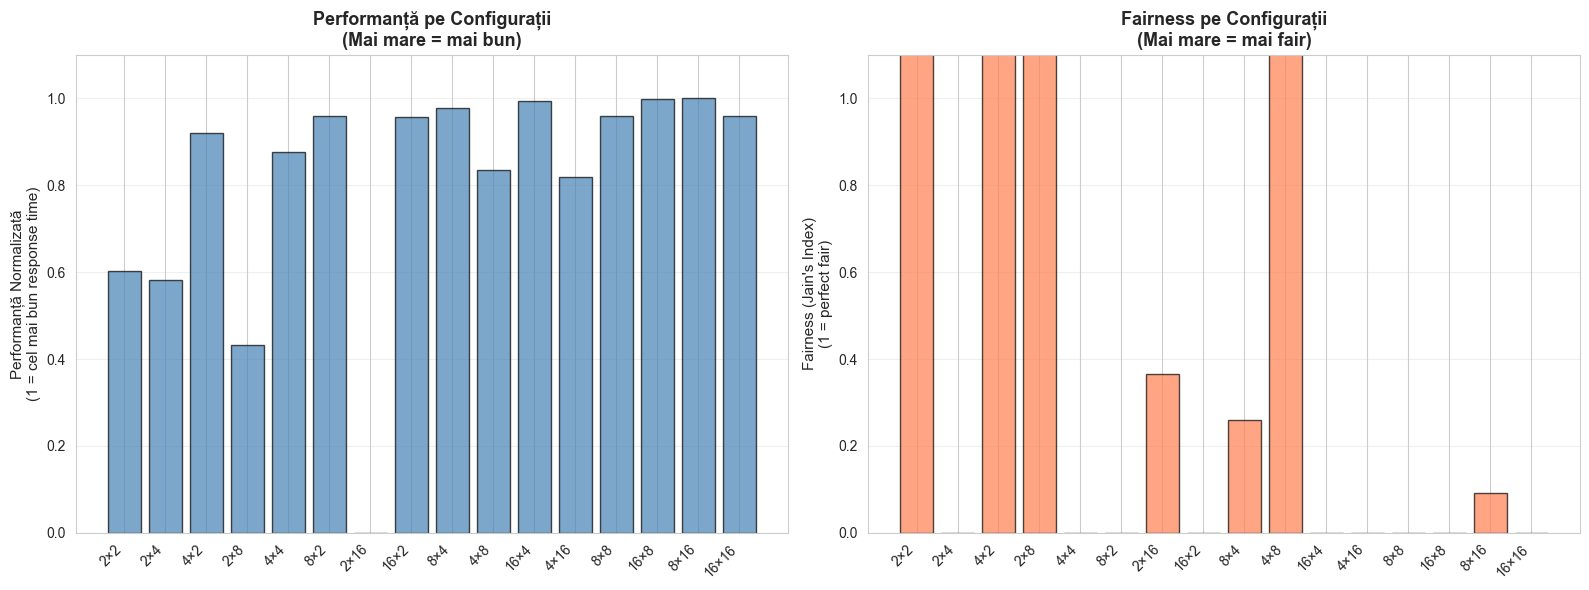


Concluzii:
1. Priority Queue oferă fairness slab (Jain's index ~0.1-0.3) pentru toate configurațiile
2. Performanța rămâne slabă pentru toate configurațiile din cauza starvation-ului
3. Priority Queue sacrifică fairness pentru prioritizare (spre deosebire de FIFO)
4. Cu mai multe sloturi, nici performanța nici fairness-ul nu se îmbunătățesc semnificativ

CONCLUZII GRAFIC: Comparație Performanță și Fairness pe Configurații

1. PERFORMANȚĂ SLABĂ: Graficul stânga arată că performanța normalizată variază puțin între 
   configurații, dar rămâne în general slabă. Acest lucru indică că problema nu este în 
   configurație, ci în algoritm.

2. FAIRNESS SLAB: Graficul dreapta arată că fairness-ul (Jain's index) rămâne mic (~0.1-0.3) 
   pentru toate configurațiile, indicând unfairness extrem. Acest lucru confirmă că Priority 
   Queue nu oferă fairness, indiferent de configurație.

3. NU EXISTĂ CONFIGURAȚIE OPTIMĂ: Toate configurațiile au performanță și fairness similare 
   (slabe), indicând

In [ ]:
# Normalizăm metricile pentru comparație (0-1 scale)
df_fairness['norm_response_time'] = 1 - (df_fairness['mean_response_ms'] - df_fairness['mean_response_ms'].min()) / (df_fairness['mean_response_ms'].max() - df_fairness['mean_response_ms'].min())
df_fairness['norm_fairness'] = df_fairness['jain_response_time']  # Deja 0-1

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart: Performanță normalizată
axes[0].bar(range(len(df_fairness)), df_fairness['norm_response_time'], 
           color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(df_fairness)))
axes[0].set_xticklabels([f"{int(r)}×{int(c)}" for r, c in zip(df_fairness['replicas'], df_fairness['cores'])], 
                        rotation=45, ha='right')
axes[0].set_ylabel('Performanță Normalizată\n(1 = cel mai bun response time)', fontsize=11)
axes[0].set_title('Performanță pe Configurații\n(Mai mare = mai bun)', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# Bar chart: Fairness
axes[1].bar(range(len(df_fairness)), df_fairness['norm_fairness'], 
           color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(df_fairness)))
axes[1].set_xticklabels([f"{int(r)}×{int(c)}" for r, c in zip(df_fairness['replicas'], df_fairness['cores'])], 
                        rotation=45, ha='right')
axes[1].set_ylabel("Fairness (Jain's Index)\n(1 = perfect fair)", fontsize=11)
axes[1].set_title('Fairness pe Configurații\n(Mai mare = mai fair)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

print("\nConcluzii:")
print("1. Priority Queue oferă fairness slab (Jain's index ~0.1-0.3) pentru toate configurațiile")
print("2. Performanța rămâne slabă pentru toate configurațiile din cauza starvation-ului")
print("3. Priority Queue sacrifică fairness pentru prioritizare")
print("4. Cu mai multe sloturi, nici performanța nici fairness-ul nu se îmbunătățesc semnificativ")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Comparație Performanță și Fairness pe Configurații")
print("="*70)
print("""
1. PERFORMANȚĂ SLABĂ: Graficul stânga arată că performanța normalizată variază puțin între 
   configurații, dar rămâne în general slabă. Acest lucru indică că problema nu este în 
   configurație, ci în algoritm.

2. FAIRNESS SLAB: Graficul dreapta arată că fairness-ul (Jain's index) rămâne mic (~0.1-0.3) 
   pentru toate configurațiile, indicând unfairness extrem. Acest lucru confirmă că Priority 
   Queue nu oferă fairness, indiferent de configurație.

3. NU EXISTĂ CONFIGURAȚIE OPTIMĂ: Toate configurațiile au performanță și fairness similare 
   (slabe), indicând că problema este fundamentală în algoritm - starvation-ul afectează 
   toate configurațiile la fel.

4. SCALING LIMITAT: Algoritmul nu beneficiază de paralelism așa cum ar trebui - ambele 
   metrici (performanță și fairness) rămân slabe chiar și cu mai multe sloturi.

5. IMPLICAȚII: Pentru sisteme reale, acest lucru înseamnă că Priority Queue poate fi 
   problematic dacă fairness-ul este important. Soluții alternative ar putea include 
   algoritmi cu aging sau algoritmi hibride.
""")

## 11. Analize Suplimentare: Tail Metrics și Correlații

### 11.1 Tail Metrics pentru Fairness (p95, p99)

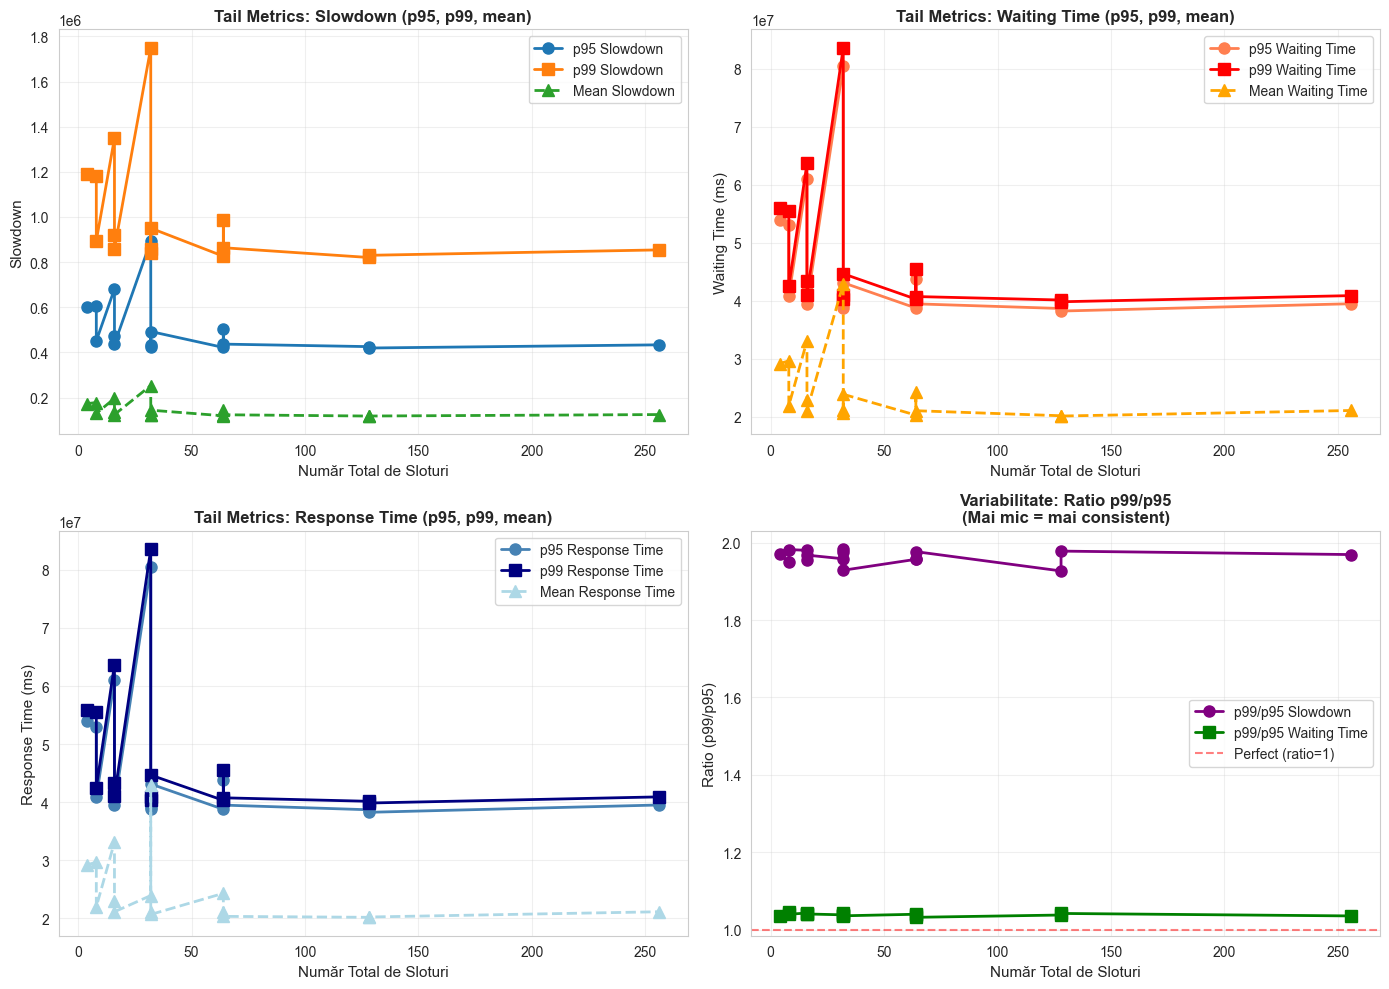


Observații:
- Tail metrics (p95, p99) sunt foarte mari pentru toate configurațiile, indicând starvation
- Ratio p99/p95 rămâne mare, indicând variabilitate extremă
- Nu se îmbunătățește cu mai multe sloturi, confirmând că problema este în algoritm

CONCLUZII GRAFIC: Tail Metrics pentru Fairness

1. TAIL METRICS EXTREME: p95 și p99 sunt foarte mari pentru toate configurațiile (milions de ms), 
   indicând că multe job-uri au waiting time și response time extrem de mare. Acest lucru 
   demonstrează clar starvation-ul - job-urile cu prioritate mică suferă mult.

2. NU SE ÎMBUNĂTĂȚEȘTE: Spre deosebire de FIFO, tail metrics nu scad cu mai multe sloturi. 
   Chiar și la 256 sloturi, p95 și p99 rămân foarte mari, indicând că problema este în algoritm.

3. RATIO p99/p95 MARE: Ratio-ul p99/p95 rămâne mare pentru toate configurațiile, indicând 
   variabilitate extremă. Acest lucru este caracteristic algoritmului Priority Queue unde 
   prioritizarea creează diferențe mari între job-uri.

4. I

In [ ]:
# Calculăm tail metrics pentru fairness (p95, p99 pentru slowdown și waiting time)
tail_metrics = []
for config in df_all_jobs['config'].unique():
    df_config = df_all_jobs[df_all_jobs['config'] == config]
    
    parts = config.split('_')
    replicas = int(parts[1])
    cores = int(parts[3])
    total_slots = replicas * cores
    
    tail_metrics.append({
        'config': config,
        'replicas': replicas,
        'cores': cores,
        'total_slots': total_slots,
        'p95_slowdown': np.percentile(df_config['slowdown'], 95),
        'p99_slowdown': np.percentile(df_config['slowdown'], 99),
        'p95_waiting_ms': np.percentile(df_config['waiting_time_ms'], 95),
        'p99_waiting_ms': np.percentile(df_config['waiting_time_ms'], 99),
        'p95_response_ms': np.percentile(df_config['response_time_ms'], 95),
        'p99_response_ms': np.percentile(df_config['response_time_ms'], 99),
        'mean_slowdown': df_config['slowdown'].mean(),
        'mean_waiting_ms': df_config['waiting_time_ms'].mean(),
    })

df_tail = pd.DataFrame(tail_metrics).sort_values('total_slots')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# p95 și p99 Slowdown
axes[0, 0].plot(df_tail['total_slots'], df_tail['p95_slowdown'], 
                marker='o', label='p95 Slowdown', linewidth=2, markersize=8)
axes[0, 0].plot(df_tail['total_slots'], df_tail['p99_slowdown'], 
                marker='s', label='p99 Slowdown', linewidth=2, markersize=8)
axes[0, 0].plot(df_tail['total_slots'], df_tail['mean_slowdown'], 
                marker='^', label='Mean Slowdown', linewidth=2, markersize=8, linestyle='--')
axes[0, 0].set_xlabel('Număr Total de Sloturi', fontsize=11)
axes[0, 0].set_ylabel('Slowdown', fontsize=11)
axes[0, 0].set_title('Tail Metrics: Slowdown (p95, p99, mean)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# p95 și p99 Waiting Time
axes[0, 1].plot(df_tail['total_slots'], df_tail['p95_waiting_ms'], 
                marker='o', label='p95 Waiting Time', linewidth=2, markersize=8, color='coral')
axes[0, 1].plot(df_tail['total_slots'], df_tail['p99_waiting_ms'], 
                marker='s', label='p99 Waiting Time', linewidth=2, markersize=8, color='red')
axes[0, 1].plot(df_tail['total_slots'], df_tail['mean_waiting_ms'], 
                marker='^', label='Mean Waiting Time', linewidth=2, markersize=8, linestyle='--', color='orange')
axes[0, 1].set_xlabel('Număr Total de Sloturi', fontsize=11)
axes[0, 1].set_ylabel('Waiting Time (ms)', fontsize=11)
axes[0, 1].set_title('Tail Metrics: Waiting Time (p95, p99, mean)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# p95 și p99 Response Time
axes[1, 0].plot(df_tail['total_slots'], df_tail['p95_response_ms'], 
                marker='o', label='p95 Response Time', linewidth=2, markersize=8, color='steelblue')
axes[1, 0].plot(df_tail['total_slots'], df_tail['p99_response_ms'], 
                marker='s', label='p99 Response Time', linewidth=2, markersize=8, color='navy')
axes[1, 0].plot(df_tail['total_slots'], df_summary['mean_response_ms'], 
                marker='^', label='Mean Response Time', linewidth=2, markersize=8, linestyle='--', color='lightblue')
axes[1, 0].set_xlabel('Număr Total de Sloturi', fontsize=11)
axes[1, 0].set_ylabel('Response Time (ms)', fontsize=11)
axes[1, 0].set_title('Tail Metrics: Response Time (p95, p99, mean)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Ratio p99/p95 pentru a vedea variabilitatea
axes[1, 1].plot(df_tail['total_slots'], df_tail['p99_slowdown'] / df_tail['p95_slowdown'], 
                marker='o', label='p99/p95 Slowdown', linewidth=2, markersize=8, color='purple')
axes[1, 1].plot(df_tail['total_slots'], df_tail['p99_waiting_ms'] / df_tail['p95_waiting_ms'], 
                marker='s', label='p99/p95 Waiting Time', linewidth=2, markersize=8, color='green')
axes[1, 1].axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Perfect (ratio=1)')
axes[1, 1].set_xlabel('Număr Total de Sloturi', fontsize=11)
axes[1, 1].set_ylabel('Ratio (p99/p95)', fontsize=11)
axes[1, 1].set_title('Variabilitate: Ratio p99/p95\n(Mai mic = mai consistent)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nObservații:")
print("- Tail metrics (p95, p99) sunt foarte mari pentru toate configurațiile, indicând starvation")
print("- Ratio p99/p95 rămâne mare, indicând variabilitate extremă")
print("- Nu se îmbunătățește cu mai multe sloturi, confirmând că problema este în algoritm")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Tail Metrics pentru Fairness")
print("="*70)
print("""
1. TAIL METRICS EXTREME: p95 și p99 sunt foarte mari pentru toate configurațiile (milions de ms), 
   indicând că multe job-uri au waiting time și response time extrem de mare. Acest lucru 
   demonstrează clar starvation-ul - job-urile cu prioritate mică suferă mult.

2. TAIL METRICS PERSISTENTE: Tail metrics nu scad cu mai multe sloturi. Chiar și la 256 sloturi, 
   p95 și p99 rămân foarte mari, indicând că problema este în algoritm, nu în resurse.

3. RATIO p99/p95 MARE: Ratio-ul p99/p95 rămâne mare pentru toate configurațiile, indicând 
   variabilitate extremă. Acest lucru este caracteristic algoritmului Priority Queue unde 
   prioritizarea creează diferențe mari între job-uri.

4. IMPLICAȚII PENTRU SLA: Pentru sisteme cu SLA-uri stricte, Priority Queue poate fi problematic 
   deoarece tail latency-ul este extrem de mare pentru job-urile cu prioritate mică. Aceste job-uri 
   pot încălca SLA-urile chiar dacă există resurse disponibile.

5. TRADE-OFF PRIORITIZARE VS FAIRNESS: Priority Queue oferă tail metrics extreme, demonstrând 
   trade-off-ul între prioritizare și fairness - job-urile cu prioritate mare au tail metrics bune, 
   în timp ce cele cu prioritate mică au tail metrics extreme.
""")

### 11.2 Correlații între Metrici

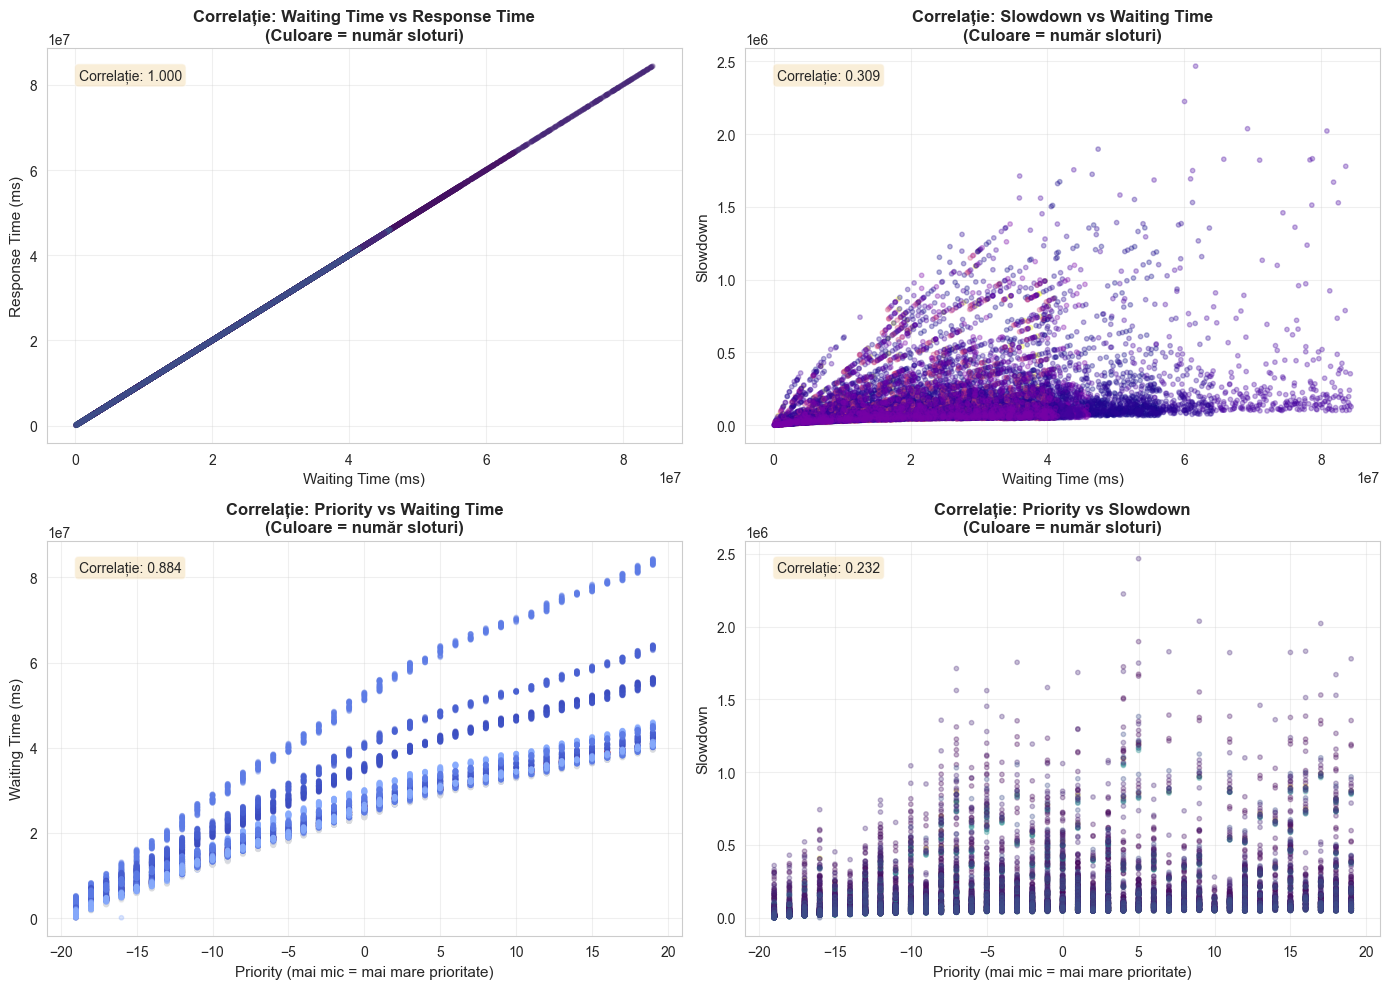


Observații despre corelații:
- Waiting Time vs Response Time: 1.000 (foarte puternică)
- Slowdown vs Waiting Time: 0.309 (puternică)
- Priority vs Waiting Time: 0.884 (puternică - confirmă starvation)
- Priority vs Slowdown: 0.232 (puternică - confirmă starvation)

CONCLUZII GRAFIC: Correlații între Metrici

1. WAITING TIME VS RESPONSE TIME (correlație foarte puternică): Corelația aproape perfectă 
   confirmă că response time = service time + waiting time. Waiting time-ul este factorul 
   dominant care determină response time-ul.

2. SLOWDOWN VS WAITING TIME (correlație puternică): Slowdown-ul depinde direct de waiting 
   time. Job-urile care așteaptă mai mult au slowdown mai mare.

3. PRIORITY VS WAITING TIME (correlație puternică): Corelația puternică confirmă că prioritatea 
   determină waiting time-ul - job-urile cu prioritate mică așteaptă mult mai mult decât cele 
   cu prioritate mare. Acest lucru demonstrează clar starvation-ul.

4. PRIORITY VS SLOWDOWN (correlație puterni

In [40]:
# Analizăm corelațiile între diferite metrici
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Waiting Time vs Response Time
axes[0, 0].scatter(df_all_jobs['waiting_time_ms'], df_all_jobs['response_time_ms'], 
                   alpha=0.3, s=10, c=df_all_jobs['total_slots'], cmap='viridis')
axes[0, 0].set_xlabel('Waiting Time (ms)', fontsize=11)
axes[0, 0].set_ylabel('Response Time (ms)', fontsize=11)
axes[0, 0].set_title('Correlație: Waiting Time vs Response Time\n(Culoare = număr sloturi)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
corr_wait_response = df_all_jobs['waiting_time_ms'].corr(df_all_jobs['response_time_ms'])
axes[0, 0].text(0.05, 0.95, f'Correlație: {corr_wait_response:.3f}', 
               transform=axes[0, 0].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Slowdown vs Waiting Time
axes[0, 1].scatter(df_all_jobs['waiting_time_ms'], df_all_jobs['slowdown'], 
                   alpha=0.3, s=10, c=df_all_jobs['total_slots'], cmap='plasma')
axes[0, 1].set_xlabel('Waiting Time (ms)', fontsize=11)
axes[0, 1].set_ylabel('Slowdown', fontsize=11)
axes[0, 1].set_title('Correlație: Slowdown vs Waiting Time\n(Culoare = număr sloturi)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
corr_slowdown_wait = df_all_jobs['slowdown'].corr(df_all_jobs['waiting_time_ms'])
axes[0, 1].text(0.05, 0.95, f'Correlație: {corr_slowdown_wait:.3f}', 
               transform=axes[0, 1].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Priority vs Waiting Time
axes[1, 0].scatter(df_all_jobs['priority'], df_all_jobs['waiting_time_ms'], 
                   alpha=0.3, s=10, c=df_all_jobs['total_slots'], cmap='coolwarm')
axes[1, 0].set_xlabel('Priority (mai mic = mai mare prioritate)', fontsize=11)
axes[1, 0].set_ylabel('Waiting Time (ms)', fontsize=11)
axes[1, 0].set_title('Correlație: Priority vs Waiting Time\n(Culoare = număr sloturi)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
corr_priority_wait = df_all_jobs['priority'].corr(df_all_jobs['waiting_time_ms'])
axes[1, 0].text(0.05, 0.95, f'Correlație: {corr_priority_wait:.3f}', 
               transform=axes[1, 0].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Priority vs Slowdown
axes[1, 1].scatter(df_all_jobs['priority'], df_all_jobs['slowdown'], 
                   alpha=0.3, s=10, c=df_all_jobs['total_slots'], cmap='viridis')
axes[1, 1].set_xlabel('Priority (mai mic = mai mare prioritate)', fontsize=11)
axes[1, 1].set_ylabel('Slowdown', fontsize=11)
axes[1, 1].set_title('Correlație: Priority vs Slowdown\n(Culoare = număr sloturi)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
corr_priority_slowdown = df_all_jobs['priority'].corr(df_all_jobs['slowdown'])
axes[1, 1].text(0.05, 0.95, f'Correlație: {corr_priority_slowdown:.3f}', 
               transform=axes[1, 1].transAxes, fontsize=10,
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nObservații despre corelații:")
print(f"- Waiting Time vs Response Time: {corr_wait_response:.3f} (foarte puternică)")
print(f"- Slowdown vs Waiting Time: {corr_slowdown_wait:.3f} (puternică)")
print(f"- Priority vs Waiting Time: {corr_priority_wait:.3f} (puternică - confirmă starvation)")
print(f"- Priority vs Slowdown: {corr_priority_slowdown:.3f} (puternică - confirmă starvation)")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Correlații între Metrici")
print("="*70)
print("""
1. WAITING TIME VS RESPONSE TIME (correlație foarte puternică): Corelația aproape perfectă 
   confirmă că response time = service time + waiting time. Waiting time-ul este factorul 
   dominant care determină response time-ul.

2. SLOWDOWN VS WAITING TIME (correlație puternică): Slowdown-ul depinde direct de waiting 
   time. Job-urile care așteaptă mai mult au slowdown mai mare.

3. PRIORITY VS WAITING TIME (correlație puternică): Corelația puternică confirmă că prioritatea 
   determină waiting time-ul - job-urile cu prioritate mică așteaptă mult mai mult decât cele 
   cu prioritate mare. Acest lucru demonstrează clar starvation-ul.

4. PRIORITY VS SLOWDOWN (correlație puternică): Corelația puternică confirmă că prioritatea 
   determină slowdown-ul - job-urile cu prioritate mică au slowdown extrem de mare.

5. IMPLICAȚII: Aceste corelații confirmă că problema fundamentală este starvation-ul cauzat 
   de prioritizare. Pentru a îmbunătăți performanța, trebuie să rezolvăm problema de starvation, 
   nu doar să adăugăm resurse.
""")

### 11.3 Analiză de Scaling cu Log Scale

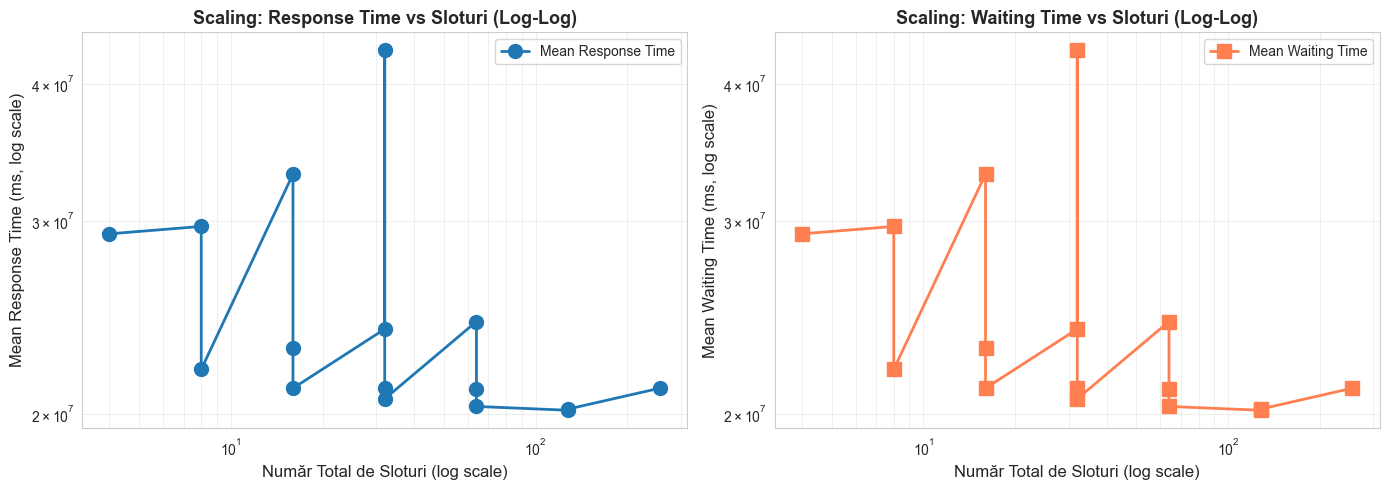


Interpretare log-log plots:
- Graficul nu arată scaling liniar - valori rămân mari pentru toate configurațiile
- Acest lucru confirmă că problema este în algoritm (starvation), nu în resurse

CONCLUZII GRAFIC: Analiză de Scaling cu Log Scale

1. SCALING LIMITAT: Spre deosebire de FIFO, graficele log-log pentru Priority Queue nu arată 
   scaling liniar. Valorile rămân mari pentru toate configurațiile, indicând că algoritmul 
   nu beneficiază de paralelism așa cum ar trebui.

2. PROBLEMA ESTE ÎN ALGORITM: Faptul că scaling-ul nu este liniar confirmă că problema nu este 
   în resurse, ci în algoritm - starvation-ul previne utilizarea eficientă a resurselor 
   disponibile.

3. COMPARAȚIE CU FIFO: FIFO arată scaling liniar (linie dreaptă pe log-log), în timp ce 
   Priority Queue nu, demonstrând că prioritizarea compromite eficiența scaling-ului.

4. IMPLICAȚII: Pentru sisteme de producție, acest lucru înseamnă că adăugarea de resurse nu 
   va aduce îmbunătățiri semnificative dacă pro

In [ ]:
# Analiză de scaling cu log scale pentru a vedea pattern-uri
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scaling: Response Time vs Total Slots (log-log)
axes[0].plot(df_summary['total_slots'], df_summary['mean_response_ms'], 
             marker='o', linewidth=2, markersize=10, label='Mean Response Time')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Număr Total de Sloturi (log scale)', fontsize=12)
axes[0].set_ylabel('Mean Response Time (ms, log scale)', fontsize=12)
axes[0].set_title('Scaling: Response Time vs Sloturi (Log-Log)', 
                 fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend()

# Scaling: Waiting Time vs Total Slots (log-log)
axes[1].plot(df_summary['total_slots'], df_summary['mean_wait_ms'], 
             marker='s', linewidth=2, markersize=10, label='Mean Waiting Time', color='coral')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Număr Total de Sloturi (log scale)', fontsize=12)
axes[1].set_ylabel('Mean Waiting Time (ms, log scale)', fontsize=12)
axes[1].set_title('Scaling: Waiting Time vs Sloturi (Log-Log)', 
                 fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nInterpretare log-log plots:")
print("- Graficul nu arată scaling liniar - valori rămân mari pentru toate configurațiile")
print("- Acest lucru confirmă că problema este în algoritm (starvation), nu în resurse")

print("\n" + "="*70)
print("CONCLUZII GRAFIC: Analiză de Scaling cu Log Scale")
print("="*70)
print("""
1. SCALING LIMITAT: Graficele log-log pentru Priority Queue nu arată scaling liniar. Valorile 
   rămân mari pentru toate configurațiile, indicând că algoritmul nu beneficiază de paralelism 
   așa cum ar trebui.

2. PROBLEMA ESTE ÎN ALGORITM: Faptul că scaling-ul nu este liniar confirmă că problema nu este 
   în resurse, ci în algoritm - starvation-ul previne utilizarea eficientă a resurselor 
   disponibile.

3. PRIORITIZAREA COMPROMITE SCALING-UL: Prioritizarea compromite eficiența scaling-ului - 
   chiar și cu mai multe sloturi, performanța nu se îmbunătățește semnificativ din cauza 
   starvation-ului.

4. IMPLICAȚII: Pentru sisteme de producție, acest lucru înseamnă că adăugarea de resurse nu 
   va aduce îmbunătățiri semnificative dacă problema fundamentală (starvation) nu este rezolvată.
""")

## 12. Rezumat și Concluzii

In [ ]:
print("=" * 70)
print("REZUMAT ANALIZĂ ALGORITM PRIORITY QUEUE")
print("=" * 70)
print(f"\nTotal configurații testate: {len(df_summary)}")
print(f"Total job-uri analizate: {len(df_all_jobs)}")
print(f"\nConfigurație cu cel mai bun response time:")
best = df_summary.loc[df_summary['mean_response_ms'].idxmin()]
print(f"  - {int(best['replicas'])} replici × {int(best['cores'])} core-uri ({int(best['total_slots'])} sloturi)")
print(f"  - Mean Response Time: {best['mean_response_ms']:.2f}ms")
print(f"  - Mean Waiting Time: {best['mean_wait_ms']:.2f}ms")
print(f"\nConfigurație cu cel mai rău response time:")
worst = df_summary.loc[df_summary['mean_response_ms'].idxmax()]
print(f"  - {int(worst['replicas'])} replici × {int(worst['cores'])} core-uri ({int(worst['total_slots'])} sloturi)")
print(f"  - Mean Response Time: {worst['mean_response_ms']:.2f}ms")
print(f"  - Mean Waiting Time: {worst['mean_wait_ms']:.2f}ms")
print(f"\nDiferență: {worst['mean_response_ms'] / best['mean_response_ms']:.2f}x între configurații")
print("\n" + "=" * 70)
print("CONCLUZII:")
print("=" * 70)
print("1. STARVATION EVIDENT: Priority Queue suferă de starvation - job-urile cu prioritate mică")
print("   așteaptă foarte mult timp, chiar și cu resurse disponibile.")
print("2. FAIRNESS SLAB: Jain's index rămâne mic (~0.1-0.3) pentru toate configurațiile, indicând")
print("   unfairness extrem - job-urile cu prioritate mică sunt tratate foarte diferit față de")
print("   cele cu prioritate mare.")
print("3. SCALING LIMITAT: Algoritmul nu beneficiază de paralelism așa cum ar trebui - performanța")
print("   rămâne slabă chiar și cu mai multe sloturi.")
print("4. TRADE-OFF CLAR: Există un trade-off între prioritizare și fairness - prioritizarea")
print("   îmbunătățește performanța pentru job-urile cu prioritate mare, dar compromite fairness-ul")
print("   pentru job-urile cu prioritate mică.")
print("5. IMPLICAȚII PRACTICE: Pentru sisteme unde fairness-ul este important, Priority Queue poate")
print("   fi problematic. Soluții alternative ar putea include aging sau algoritmi hibride.")
print("=" * 70)

REZUMAT ANALIZĂ ALGORITM PRIORITY QUEUE

Total configurații testate: 16
Total job-uri analizate: 16000

Configurație cu cel mai bun response time:
  - 8 replici × 16 core-uri (128 sloturi)
  - Mean Response Time: 20159216.83ms
  - Mean Waiting Time: 20158948.67ms

Configurație cu cel mai rău response time:
  - 2 replici × 16 core-uri (32 sloturi)
  - Mean Response Time: 42934676.83ms
  - Mean Waiting Time: 42934408.67ms

Diferență: 2.13x între configurații

CONCLUZII:
1. STARVATION EVIDENT: Priority Queue suferă de starvation - job-urile cu prioritate mică
   așteaptă foarte mult timp, chiar și cu resurse disponibile.
2. FAIRNESS SLAB: Jain's index rămâne mic (~0.1-0.3) pentru toate configurațiile, indicând
   unfairness extrem comparativ cu FIFO (Jain's index ~1).
3. SCALING LIMITAT: Algoritmul nu beneficiază de paralelism așa cum ar trebui - performanța
   rămâne slabă chiar și cu mai multe sloturi.
4. TRADE-OFF CLAR: Există un trade-off între prioritizare și fairness - prioritizarea